In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import pyarrow.parquet as pq
import statsmodels.api as sm
from tqdm.notebook import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy import signal
import multiprocessing as mp
from functools import partial, lru_cache
import traceback
import time

In [ ]:
# Import Stock Data
universe = pd.read_parquet('crsp.msf_delisting_adjusted.parquet',columns=['ticker','date','prc', 'vol', 'ret','shrout','yearmonth'])
universe['mktcap'] = abs(universe['prc']) * universe['shrout']
universe['date'] = pd.to_datetime(universe['date'])
universe = universe[universe['date']>= '2018-01-01']
universe = universe.dropna()
universe.head(10)

,ticker,date,prc,vol,ret,shrout,yearmonth,mktcap
4200,JJSF,2021-04-30,164.610001,24625.0,0.048271,19036.0,2021-04,3.133516e+06
4201,JJSF,2021-05-28,175.580002,13818.0,0.066642,19036.0,2021-05,3.342341e+06
4202,JJSF,2021-06-30,174.410004,22259.0,-0.003058,19061.0,2021-06,3.324429e+06
4203,JJSF,2021-07-30,164.380005,13204.0,-0.057508,19064.0,2021-07,3.133740e+06
4204,JJSF,2021-08-31,163.759995,10902.0,-0.003772,19064.0,2021-08,3.121921e+06
4205,JJSF,2021-09-30,152.820007,14739.0,-0.062940,19084.0,2021-09,2.916417e+06
4206,JJSF,2021-10-29,147.550003,10034.0,-0.034485,19084.0,2021-10,2.815844e+06
4207,JJSF,2021-11-30,136.580002,12612.0,-0.074348,19085.0,2021-11,2.606629e+06
4208,JJSF,2021-12-31,157.960007,21208.0,0.161173,19089.0,2021-12,3.015299e+06
4209,JJSF,2022-01-31,151.690002,14878.0,-0.039694,19110.0,2022-01,2.898796e+06


In [ ]:
#Import SPY Data
spy = yf.download('SPY', start='2018-01-01', end='2024-01-01')['Close']
spy_return = spy.pct_change().dropna()
spy_monthly_return = spy_return.resample('M').agg(lambda x: (x + 1).prod() - 1)
spy_monthly_return = spy_monthly_return.rename_axis('date')
spy_monthly_return.columns = ['ret']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Setup

In [ ]:
# Function to time execution
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"{func.__name__} completed in {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
        return result
    return wrapper

In [ ]:
# Prepare data optimized for top market cap stocks
@timeit
def prepare_data_optimized(universe_df, min_periods=2, top_mktcap=500):

    print("Pre-filtering data...")

    universe_df['date'] = pd.to_datetime(universe_df['date'])

    # Count observations per ticker
    ticker_counts = universe_df['ticker'].value_counts()
    valid_tickers_by_count = ticker_counts[ticker_counts >= min_periods].index.tolist()
    print(f"Found {len(valid_tickers_by_count)} tickers with at least {min_periods} observations")

    # Initial filtering to keep only tickers with sufficient history
    filtered_universe = universe_df[universe_df['ticker'].isin(valid_tickers_by_count)]

    # For each month, find the top N tickers by market cap
    print("Finding top market cap tickers for each month...")

    # Group by year-month and get the top market cap tickers for each month
    top_tickers_by_month = {}
    months = filtered_universe['yearmonth'].unique()

    for month in tqdm(months, desc="Processing months"):

        month_data = filtered_universe[filtered_universe['yearmonth'] == month]

        # For each ticker, get the latest market cap value in this month
        latest_mktcap = (month_data
                        .sort_values('date')
                        .drop_duplicates('ticker', keep='last')
                        .sort_values('mktcap', ascending=False))

        # Get top N tickers by market cap for this month
        top_month_tickers = latest_mktcap.head(top_mktcap)['ticker'].tolist()
        top_tickers_by_month[month] = set(top_month_tickers)

    # Create a mask to filter for top market cap tickers in each month
    print("Filtering for top market cap tickers in each month...")
    filtered_universe = filtered_universe[
        filtered_universe.apply(
            lambda row: row['ticker'] in top_tickers_by_month.get(row['yearmonth'], set()),
            axis=1
        )
    ]

    print(f"After filtering: {len(filtered_universe)} observations for top market cap tickers")


    print("Handling duplicates...")
    filtered_universe = (filtered_universe
                        .sort_values('date')
                        .drop_duplicates(['ticker', 'date'], keep='last'))

    # Create returns dataframe using pivot_table
    print("Creating returns panel...")
    returns_df = filtered_universe.pivot_table(
        index='date',
        columns='ticker',
        values='ret',
        aggfunc='last'
    )

    # Convert index to datetime if needed
    if not isinstance(returns_df.index, pd.DatetimeIndex):
        returns_df.index = pd.to_datetime(returns_df.index)

    # Sort by date
    returns_df = returns_df.sort_index()

    # Report final shape
    unique_dates = returns_df.index.nunique()
    unique_tickers = returns_df.columns.nunique()
    print(f"Final returns dataframe shape: {returns_df.shape} ({unique_dates} dates × {unique_tickers} unique tickers)")
    print(f"Note: The number of tickers varies monthly, with up to {top_mktcap} per month")

    return returns_df

# Lead-lag Calculation

In [ ]:
def levy_area(returns_i, returns_j):

  if isinstance(returns_i, pd.Series):
      returns_i = returns_i.values
  if isinstance(returns_j, pd.Series):
      returns_j = returns_j.values

  # Calculate Lévy area
  return np.sum(returns_i[:-1] * returns_j[1:] - returns_j[:-1] * returns_i[1:]) / 2

In [ ]:
def max_cross_corr(returns_i_tuple, returns_j_tuple, max_lag=5):
    """CPU version of maximum cross-correlation with better error handling"""
    # Convert tuple back to numpy array
    returns_i = np.array(returns_i_tuple)
    returns_j = np.array(returns_j_tuple)

    # Add debugging for first pair
    debug = False
    if len(returns_i) <= 5 and len(returns_j) <= 5:
        debug = True
        print(f"DEBUG DATA: returns_i = {returns_i}")
        print(f"DEBUG DATA: returns_j = {returns_j}")

    # Pre-compute stats to avoid repeated calculations
    mean_i = np.mean(returns_i)
    mean_j = np.mean(returns_j)
    std_i = np.std(returns_i)
    std_j = np.std(returns_j)

    if debug:
        print(f"DEBUG: mean_i={mean_i}, mean_j={mean_j}, std_i={std_i}, std_j={std_j}")

    if std_i == 0 or std_j == 0:
        if debug:
            print("DEBUG: Zero standard deviation detected, returning (0, 0)")
        return (0, 0)

    # Fast correlation calculation
    corrs = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            # j leads i
            if len(returns_i) + lag <= 1:
                continue
            x = returns_i[-lag:]
            y = returns_j[:lag]
        elif lag > 0:
            # i leads j
            if len(returns_i) - lag <= 1:
                continue
            x = returns_i[:-lag]
            y = returns_j[lag:]
        else:
            x = returns_i
            y = returns_j

        if len(x) <= 1 or len(y) <= 1:
            if debug:
                print(f"DEBUG: Skipping lag {lag} - resulting series too short")
            continue

        # Fast manual correlation calculation
        x_norm = (x - mean_i) / std_i
        y_norm = (y - mean_j) / std_j
        corr = np.mean(x_norm * y_norm)
        if debug:
            print(f"DEBUG: Lag {lag} - x={x}, y={y}, corr={corr}")

        corrs.append((lag, corr))

    if not corrs:
        if debug:
            print("DEBUG: No valid correlations found, returning (0, 0)")
        return (0, 0)

    non_zero_corrs = [c for c in corrs if c[0] != 0]

    if non_zero_corrs:
        result = max(non_zero_corrs, key=lambda x: abs(x[1]))
        if debug:
            print(f"DEBUG: Selected max non-zero lag: {result}")
        return result
    else:
        # If only lag=0 is available, return it
        result = max(corrs, key=lambda x: abs(x[1]))
        if debug:
            print(f"DEBUG: Only lag=0 available, returning: {result}")
        return result

In [ ]:
import numba as nb

@nb.njit(fastmath=True)
def _fast_pearson(x, y):
    """Fast Pearson correlation implementation with Numba"""
    n = len(x)

    # Calculate means
    mean_x = 0.0
    mean_y = 0.0
    for i in range(n):
        mean_x += x[i]
        mean_y += y[i]
    mean_x /= n
    mean_y /= n

    # Calculate correlation
    numerator = 0.0
    sum_sq_x = 0.0
    sum_sq_y = 0.0

    for i in range(n):
        x_diff = x[i] - mean_x
        y_diff = y[i] - mean_y
        numerator += x_diff * y_diff
        sum_sq_x += x_diff * x_diff
        sum_sq_y += y_diff * y_diff

    denominator = np.sqrt(sum_sq_x * sum_sq_y)

    if denominator == 0:
        return 0.0
    else:
        return numerator / denominator

@nb.njit(fastmath=True)
def fast_avg_cross_corr(returns_i, returns_j, max_lag=5):
    """
    Ultra-fast implementation using Numba JIT compilation.
    """
    # Pre-allocate arrays
    n = len(returns_i)
    pos_lags = np.zeros(max_lag)
    neg_lags = np.zeros(max_lag)
    pos_valid_count = 0
    neg_valid_count = 0

    # Calculate correlations
    for lag in range(1, max_lag + 1):
        if n > lag:
            # Positive lags (i leads j)
            x_pos = returns_i[:-lag]
            y_pos = returns_j[lag:]

            if len(x_pos) > 1:
                corr_pos = _fast_pearson(x_pos, y_pos)
                if not np.isnan(corr_pos):
                    pos_lags[lag-1] = corr_pos
                    pos_valid_count += 1

            # Negative lags (j leads i)
            x_neg = returns_i[lag:]
            y_neg = returns_j[:-lag]

            if len(x_neg) > 1:
                corr_neg = _fast_pearson(x_neg, y_neg)
                if not np.isnan(corr_neg):
                    neg_lags[lag-1] = corr_neg
                    neg_valid_count += 1

    # Compute results
    if pos_valid_count > 0 and neg_valid_count > 0:
        pos_sum = 0.0
        for i in range(max_lag):
            if pos_lags[i] != 0.0:
                pos_sum += pos_lags[i]

        neg_sum = 0.0
        for i in range(max_lag):
            if neg_lags[i] != 0.0:
                neg_sum += neg_lags[i]

        return (pos_sum / pos_valid_count) - (neg_sum / neg_valid_count)
    elif pos_valid_count > 0:
        pos_sum = 0.0
        for i in range(max_lag):
            if pos_lags[i] != 0.0:
                pos_sum += pos_lags[i]
        return pos_sum / pos_valid_count
    elif neg_valid_count > 0:
        neg_sum = 0.0
        for i in range(max_lag):
            if neg_lags[i] != 0.0:
                neg_sum += neg_lags[i]
        return -(neg_sum / neg_valid_count)
    else:
        return 0.0

def avg_cross_corr(returns_i, returns_j, max_lag=5):
    """
    Wrapper function that handles input conversion and NaN filtering
    before calling the optimized Numba implementation.
    """
    # Convert to numpy arrays
    if not isinstance(returns_i, np.ndarray):
        returns_i = np.asarray(returns_i)
    if not isinstance(returns_j, np.ndarray):
        returns_j = np.asarray(returns_j)

    # Handle NaN values
    valid_indices = ~(np.isnan(returns_i) | np.isnan(returns_j))
    if np.sum(valid_indices) < 2:
        return 0  # Not enough valid data points

    # Filter arrays
    returns_i_valid = returns_i[valid_indices]
    returns_j_valid = returns_j[valid_indices]

    # Call the fast implementation
    return fast_avg_cross_corr(returns_i_valid, returns_j_valid, max_lag)

## Compute Pairs

In [ ]:
def compute_pair(i, j, returns_df, method, max_lag):
    """Helper function for parallel processing with improved error handling"""
    try:
        # Get series
        series_i = returns_df.iloc[:, i].values
        series_j = returns_df.iloc[:, j].values

        # Early return if not enough data
        if len(series_i) < 2 or len(series_j) < 2:
            return i, j, 0

        # Quick check for NaNs
        if np.isnan(series_i).any() or np.isnan(series_j).any():
            return i, j, 0

        # Fast std calculation
        std_i = np.std(series_i)
        std_j = np.std(series_j)

        if std_i == 0 or std_j == 0:
            return i, j, 0

        # Fast standardization
        mean_i = np.mean(series_i)
        mean_j = np.mean(series_j)
        std_series_i = (series_i - mean_i) / std_i
        std_series_j = (series_j - mean_j) / std_j

        # DEBUG: Print method being used
        #if i == 0 and j == 1:  # Only print for the first pair to avoid flooding
        #    print(f"DEBUG: Using method '{method}' for pair (0,1)")

        # Compute score based on method
        if method == 'levy_area':
            score = levy_area(std_series_i, std_series_j)
            #if i == 0 and j == 1:
                #print(f"DEBUG: levy_area score for pair (0,1): {score}")
            #if i == 0 and j == 2:
                #print(f"DEBUG: levy_area score for pair (0,2): {score}")
        elif method == 'max_corr':
            # Convert to tuple for caching
            lag, corr = max_cross_corr(tuple(series_i), tuple(series_j), max_lag)
            score = lag * corr
            #if i == 0 and j == 1:
                #print(f"DEBUG: max_corr score for pair (0,1): {score} (lag={lag}, corr={corr})")
            #if i == 0 and j == 2:
                #print(f"DEBUG: max_corr score for pair (0,2): {score} (lag={lag}, corr={corr})")
        elif method == 'avg_corr':
            score = avg_cross_corr(series_i, series_j, max_lag)
            #if i == 0 and j == 1:
                #print(f"DEBUG: avg_corr score for pair (0,1): {score}")
            #if i == 0 and j == 2:
                #print(f"DEBUG: avg_corr score for pair (0,2): {score}")
        else:
            score = 0
            if i == 0 and j == 1:
                print(f"DEBUG: Unknown method '{method}', using score 0")


        return i, j, score
    except Exception as e:
        print(f"Error computing pair ({i},{j}): {e}")
        return i, j, 0

In [ ]:
# Function to compute lead-lag matrix with parallelization
@timeit
def compute_lead_lag_matrix(returns_df, method, max_lag=10, batch_size=500):
    """
    Compute lead-lag matrix using parallelization
    """
    n_stocks = returns_df.shape[1]
    lead_lag_matrix = np.zeros((n_stocks, n_stocks))

    # Create pairs for upper triangle to avoid redundant calculations
    pairs = [(i, j) for i in range(n_stocks) for j in range(i+1, n_stocks)]
    total_pairs = len(pairs)

    print(f"Computing {method} lead-lag matrix for {total_pairs} pairs...")

    # Optimal batch size
    if not batch_size:
        batch_size = min(1000, max(100, total_pairs // (mp.cpu_count() * 2)))

    results = []

    # Process in batches with progress tracking and limited workers
    with mp.Pool(processes=mp.cpu_count()) as pool:
        for i in tqdm(range(0, total_pairs, batch_size), desc=f"Computing {method} batches"):
            batch_pairs = pairs[i:min(i+batch_size, total_pairs)]

            try:
                batch_results = pool.starmap(
                    partial(compute_pair, returns_df=returns_df, method=method, max_lag=max_lag),
                    batch_pairs
                )
                results.extend(batch_results)
            except Exception as e:
                print(f"Error in batch {i//batch_size}: {e}")
                # Continue with next batch instead of failing completely

    # Fill the matrix with results, ignoring errors
    for result in results:
        if result is not None:
            i, j, score = result
            lead_lag_matrix[i, j] = score
            lead_lag_matrix[j, i] = -score

    return lead_lag_matrix

In [ ]:
@lru_cache(maxsize=128)
def cached_rank_calculation(matrix_tuple):
    """Cache the ranking calculation using a hashable input"""
    matrix = np.array(matrix_tuple)
    column_means = np.mean(matrix, axis=0)
    ranked_indices = np.argsort(-column_means)
    return ranked_indices, column_means

def rank_stocks(lead_lag_matrix):
    """
    Rank stocks from leaders to followers based on column averages of lead-lag matrix.
    """
    # Convert matrix to tuple for hashing (needed for caching)
    matrix_tuple = tuple(map(tuple, lead_lag_matrix))
    return cached_rank_calculation(matrix_tuple)

# Construct Portfolio

In [ ]:
def construct_portfolio(returns_df, ranked_indices, market_returns, n_leaders=0.2, n_followers=0.2):
    """
    Construct lead-lag portfolio using Algorithm 1 from the paper.
    """
    n_stocks = returns_df.shape[1]
    n_leaders_count = max(1, int(n_stocks * n_leaders))
    n_followers_count = max(1, int(n_stocks * n_followers))

    # Get leader and follower indices
    leader_indices = ranked_indices[:n_leaders_count]
    follower_indices = ranked_indices[-n_followers_count:]

    # Calculate portfolio returns
    portfolio_returns = []

    for t in range(1, len(returns_df)):
        # Calculate average return of leaders in previous period
        leader_return_t_minus_1 = returns_df.iloc[t-1, leader_indices].mean()

        # Calculate average return of followers in current period
        follower_return_t = returns_df.iloc[t, follower_indices].mean()

        # Decide position based on sign of leaders' returns
        if leader_return_t_minus_1 >= 0:
            # Long followers, short market
            portfolio_return = follower_return_t - market_return_t
        else:
            # Short followers, long market
            portfolio_return = market_return_t - follower_return_t

        portfolio_returns.append(portfolio_return)

    return pd.Series(portfolio_returns, index=returns_df.index[1:])

# Plot Performance

In [ ]:
def compute_performance(returns):
    """
    Compute performance metrics for a returns series.
    """
    monthly_return = returns.mean() * 10000  # in basis points
    annualized_return = (1 + returns.mean()) ** 12 - 1  # assuming monthly returns for annualization
    monthly_vol = returns.std() * 100  # in percentage
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(12)  # monthly to annual
    cumulative_returns = (1 + returns).cumprod() - 1

    return_peaks = returns.cummax()
    max_drawdown = (returns / return_peaks - 1).min() * 100


    metrics = {
        'Compound Return (%)': cumulative_returns * 100,
        'Monthly Return (%)': monthly_return * 100,
        'Monthly Vol. (%)': monthly_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': -max_drawdown
    }

    return metrics, cumulative_returns

In [ ]:
def plot_performance(method, returns, cumulative_returns):
    """
    Plot performance metrics for a single method
    """
    print(f"\nPerformance Results for {method}:")
    metrics, _ = compute_performance(returns)
    metrics_df = pd.DataFrame({method: metrics})

    from IPython.display import display
    display(metrics_df.T)


    # Plot cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns.index, cumulative_returns*100, label=method)
    plt.title(f'Cumulative Returns: {method}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return(%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{method}_cumulative_returns.png', dpi=300)
    plt.show()

    # Plot monthly returns
    plt.figure(figsize=(10, 6))
    returns_pct = returns * 100
    ax = returns_pct.plot(kind='bar', figsize=(10, 6))
    date_labels = [d.strftime('%Y%m') for d in returns.index]
    ax.set_xticklabels(date_labels, rotation=90)
    plt.title(f'Monthly Returns: {method}')
    plt.xlabel('Month')
    plt.ylabel('Return(%)')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{method}_monthly_returns.png', dpi=300)
    plt.show()

    # Plot rolling metrics
    if len(returns) >= 12:
        fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

        # Rolling 12-month return
        rolling_return = returns.rolling(12).apply(lambda x: (1 + x).prod() - 1) * 100
        rolling_return.plot(ax=axes[0])
        axes[0].set_title(f'Rolling 12-Month Return (%): {method}')
        axes[0].set_ylabel('Return (%)')
        axes[0].axhline(y=0, color='r', linestyle='-')
        axes[0].grid(True)

        # Rolling 12-month Sharpe ratio
        rolling_sharpe = returns.rolling(12).apply(
            lambda x: x.mean() / (x.std() + 1e-8) * np.sqrt(12)
        )
        rolling_sharpe.plot(ax=axes[1])
        axes[1].set_title(f'Rolling 12-Month Sharpe Ratio: {method}')
        axes[1].set_ylabel('Sharpe Ratio')
        axes[1].axhline(y=0, color='r', linestyle='-')
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig(f'{method}_rolling_metrics.png', dpi=300)
        plt.show()

    return metrics_df

# Benchmark Portfolios

In [ ]:
@timeit
def create_benchmark_portfolios(returns_df, universe, valid_windows, market_returns,
                               lookback_window, n_leaders_pct=0.2, n_followers_pct=0.2,
                               n_quantiles=5, debug_mode=False):
    """
    Create benchmark portfolios based on market cap, turnover, and illiquidity.

    Parameters:
    -----------
    returns_df : pd.DataFrame
        Returns data with dates as index and tickers as columns
    universe : pd.DataFrame
        Universe data with stock information
    valid_windows : dict
        Dictionary of valid windows for analysis
    market_returns : pd.Series or pd.DataFrame
        Market returns data
    lookback_window : int
        Number of periods to look back
    n_leaders_pct : float
        Percentage of stocks to consider as leaders
    n_followers_pct : float
        Percentage of stocks to consider as followers
    n_quantiles : int
        Number of quantiles for illiquidity portfolio
    debug_mode : bool
        If True, print debug information

    Returns:
    --------
    dict
        Dictionary containing benchmark returns and performance metrics
    """
    print("Creating benchmark portfolios...")
    mktcap_benchmark = []
    turnover_benchmark = []
    illiquidity_returns = []

    # Create a mapping between tickers and column indices for the entire returns_df
    global_ticker_to_index = {ticker: i for i, ticker in enumerate(returns_df.columns)}

    # Process all windows with progress bar
    for t in tqdm(range(lookback_window, len(returns_df)-1), desc="Computing benchmarks"):
        current_date = returns_df.index[t]
        prev_date = returns_df.index[t-1] if t > 0 else None

        # Skip if this window is not valid
        if t not in valid_windows:
            mktcap_benchmark.append(np.nan)
            turnover_benchmark.append(np.nan)
            illiquidity_returns.append(np.nan)
            continue

        window_data = valid_windows[t]
        valid_cols = window_data['valid_cols']

        # Get latest data for the valid tickers
        latest_data = universe[
            (universe['date'] <= current_date) &
            (universe['ticker'].isin(valid_cols))
        ]

        # Get the latest record for each ticker
        latest_data = latest_data.sort_values('date').drop_duplicates('ticker', keep='last')

        if len(latest_data) < 2:
            mktcap_benchmark.append(np.nan)
            turnover_benchmark.append(np.nan)
            illiquidity_returns.append(np.nan)
            continue

        # Create mappings for the current window
        ticker_to_index = {ticker: i for i, ticker in enumerate(valid_cols)}

        # --------- Market Cap Portfolio ---------
        # Get indices for market cap ranking
        mktcap_ranked_indices = []
        for ticker in latest_data.sort_values('mktcap', ascending=False)['ticker']:
            if ticker in ticker_to_index:
                mktcap_ranked_indices.append(ticker_to_index[ticker])

        # --------- Turnover Portfolio ---------
        # Get indices for turnover ranking (volume/shares outstanding)
        latest_data['turnover'] = latest_data['vol'] / (latest_data['shrout'] + 1e-8)
        turnover_ranked_indices = []
        for ticker in latest_data.sort_values('turnover', ascending=False)['ticker']:
            if ticker in ticker_to_index:
                turnover_ranked_indices.append(ticker_to_index[ticker])

        # --------- Illiquidity Calculation ---------
        # For illiquidity, we need data from the previous period
        if prev_date is not None:
            prev_month_data = universe[universe['date'] <= prev_date]
            prev_month_data = prev_month_data.sort_values('date').drop_duplicates('ticker', keep='last')

            # Calculate illiquidity: |return| / dollar volume
            illiquidity = {}
            valid_illiq_tickers = []

            for _, row in prev_month_data.iterrows():
                ticker = row['ticker']
                if ticker in global_ticker_to_index and ticker in valid_cols:
                    dollar_volume = row['vol'] * abs(row['prc'])

                    if dollar_volume > 0:
                        ret = returns_df.iloc[t-1, global_ticker_to_index[ticker]]
                        if not np.isnan(ret):
                            illiquidity[ticker] = abs(ret) / dollar_volume
                            valid_illiq_tickers.append(ticker)

            # Calculate high minus low illiquidity portfolio return
            if len(valid_illiq_tickers) >= n_quantiles * 2:
                # Sort tickers by illiquidity
                sorted_tickers = sorted(valid_illiq_tickers, key=lambda x: illiquidity.get(x, 0))

                # Get highest and lowest illiquidity quantiles
                n_stocks = len(sorted_tickers)
                n_per_quantile = n_stocks // n_quantiles

                if n_per_quantile > 0:
                    high_illiq_tickers = sorted_tickers[-n_per_quantile:]
                    low_illiq_tickers = sorted_tickers[:n_per_quantile]

                    # Get indices for these tickers
                    high_illiq_indices = [global_ticker_to_index[ticker] for ticker in high_illiq_tickers
                                        if ticker in global_ticker_to_index]
                    low_illiq_indices = [global_ticker_to_index[ticker] for ticker in low_illiq_tickers
                                       if ticker in global_ticker_to_index]

                    # Compute high minus low illiquidity return
                    if high_illiq_indices and low_illiq_indices:
                        high_illiq_return = returns_df.iloc[t, high_illiq_indices].mean()
                        low_illiq_return = returns_df.iloc[t, low_illiq_indices].mean()
                        illiquidity_returns.append(high_illiq_return - low_illiq_return)
                    else:
                        illiquidity_returns.append(np.nan)
                else:
                    illiquidity_returns.append(np.nan)
            else:
                illiquidity_returns.append(np.nan)
        else:
            illiquidity_returns.append(np.nan)

        # --------- Construct Lead-Lag Portfolios ---------
        # Get data for portfolio construction
        eval_df = returns_df.iloc[t:t+2][valid_cols].copy()
        current_market = market_returns.iloc[t:t+2].copy() if isinstance(market_returns, pd.Series) else market_returns['ret'].iloc[t:t+2].copy()

        # Construct market cap and turnover portfolios
        try:
            if len(mktcap_ranked_indices) >= 2:
                mktcap_return = construct_portfolio(
                    eval_df, mktcap_ranked_indices, current_market,
                    n_leaders=n_leaders_pct, n_followers=n_followers_pct
                ).iloc[0]
                mktcap_benchmark.append(mktcap_return)
            else:
                mktcap_benchmark.append(np.nan)

            if len(turnover_ranked_indices) >= 2:
                turnover_return = construct_portfolio(
                    eval_df, turnover_ranked_indices, current_market,
                    n_leaders=n_leaders_pct, n_followers=n_followers_pct
                ).iloc[0]
                turnover_benchmark.append(turnover_return)
            else:
                turnover_benchmark.append(np.nan)
        except Exception as e:
            mktcap_benchmark.append(np.nan)
            turnover_benchmark.append(np.nan)
            if debug_mode:
                print(f"DEBUG: Error constructing benchmark portfolios at {current_date}: {e}")

    # Convert to Series
    benchmark_returns = {}
    benchmark_returns['Market Cap'] = pd.Series(mktcap_benchmark, index=returns_df.index[lookback_window+1:])
    benchmark_returns['Turnover'] = pd.Series(turnover_benchmark, index=returns_df.index[lookback_window+1:])
    benchmark_returns['Illiquidity'] = pd.Series(illiquidity_returns, index=returns_df.index[lookback_window+1:])

    # Calculate performance metrics
    benchmark_metrics = {}
    benchmark_cumulative = {}
    for bench in benchmark_returns:
        returns = benchmark_returns[bench].dropna()
        if len(returns) > 0:
            cumulative_returns = (1 + returns).cumprod() - 1
            metrics_df = plot_performance(bench, returns, cumulative_returns)
            benchmark_metrics[bench] = metrics_df
            benchmark_cumulative[bench] = cumulative_returns

    return {
        'returns': benchmark_returns,
        'metrics': benchmark_metrics,
        'cumulative': benchmark_cumulative
    }

# Fama-French

In [ ]:
def get_fama_french_factors(start_date, end_date):
    """
    Read Fama-French 5 factors data from the provided CSV file
    """
    print("Reading Fama-French factors from CSV file...")
    try:
        # Read the CSV file, skipping the first few rows of description
        ff_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, index_col=0)

        month_dates = []
        for date_str in ff_data.index.astype(str):
            year = int(date_str[:4])
            month = int(date_str[4:6])
            # Get the last day of the month
            if month == 12:
                next_month = 1
                next_year = year + 1
            else:
                next_month = month + 1
                next_year = year

            last_day = (pd.Timestamp(year=next_year, month=next_month, day=1) -
                      pd.Timedelta(days=1)).day

            month_dates.append(pd.Timestamp(year=year, month=month, day=last_day))

        ff_data.index = pd.DatetimeIndex(month_dates)

        # Keep only the data within the specified date range
        start_date_dt = pd.to_datetime(start_date)
        end_date_dt = pd.to_datetime(end_date)

        # Keep only the data within the specified date range
        ff_data = ff_data.loc[(ff_data.index >= pd.to_datetime(start_date)) & (ff_data.index <= pd.to_datetime(end_date))]

        # Convert from percentage to decimal
        factors = ff_data / 100

        print(f"Successfully loaded {len(factors)} months of factor data")
        return factors
    except Exception as e:
        print(f"Error loading Fama-French factors from CSV: {e}")
        print("Creating placeholder factors data...")

        # Create placeholder data if loading fails
        dates = pd.date_range(start=start_date, end=end_date, freq='M')
        factors = pd.DataFrame(index=dates, columns=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'])
        factors.index.name = 'Date'
        factors = factors.fillna(0)
        return factors

# Performance Attribution

In [ ]:
def performance_attribution(method_returns, mktcap_returns, turnover_returns,
                           illiquidity_returns, ff_factors, method=""):
    """
    Perform regression analysis to attribute the performance of portfolio
    with improved handling of limited data
    """
    print(f"Running performance attribution for {method}...")

    # Align data with progress tracking
    print("Aligning data...")

    # Convert all inputs to Series if they're DataFrames to ensure consistent handling
    if isinstance(method_returns, pd.DataFrame):
        method_returns = method_returns.iloc[:, 0]
    if isinstance(mktcap_returns, pd.DataFrame):
        mktcap_returns = mktcap_returns.iloc[:, 0]
    if isinstance(turnover_returns, pd.DataFrame):
        turnover_returns = turnover_returns.iloc[:, 0]
    if isinstance(illiquidity_returns, pd.DataFrame):
        illiquidity_returns = illiquidity_returns.iloc[:, 0]

    # Ensure all indexes are datetime for proper alignment
    for series in [method_returns, mktcap_returns, turnover_returns, illiquidity_returns]:
        if not isinstance(series.index, pd.DatetimeIndex):
            series.index = pd.to_datetime(series.index)

    if not isinstance(ff_factors.index, pd.DatetimeIndex):
        ff_factors.index = pd.to_datetime(ff_factors.index)

    # Find common dates between all data sources, handling NaN values properly
    all_series = [
        method_returns.dropna(),
        mktcap_returns.dropna(),
        turnover_returns.dropna(),
        illiquidity_returns.dropna()
    ]

    # Get dates present in all series
    common_index = all_series[0].index
    for series in all_series[1:]:
        common_index = common_index.intersection(series.index)

    # Also intersect with FF factors dates
    common_index = common_index.intersection(ff_factors.index)

    if len(common_index) < 10:
        print(f"Warning: Not enough common dates for attribution ({len(common_index)} dates)")
        empty_df = pd.DataFrame()
        return {
            'table1': empty_df,
            'table8': empty_df
        }

    # Align all data to common dates
    port_ret = method_returns.loc[common_index]
    mkt_ret = ff_factors['Mkt-RF'].loc[common_index]
    smb_ret = ff_factors['SMB'].loc[common_index]
    hml_ret = ff_factors['HML'].loc[common_index]
    rmw_ret = ff_factors['RMW'].loc[common_index]
    cma_ret = ff_factors['CMA'].loc[common_index]
    rf_ret = ff_factors['RF'].loc[common_index]
    illiq_ret = illiquidity_returns.loc[common_index]
    print("Check illiq_ret")
    print(illiq_ret.iloc[:3])

    # Create excess returns
    port_excess = port_ret - rf_ret

    # Align benchmark returns
    if mktcap_returns is not None:
        mktcap_common = common_index.intersection(mktcap_returns.index)
        mktcap_returns = mktcap_returns.loc[mktcap_common]
    else:
        mktcap_returns = None

    if turnover_returns is not None:
        turnover_common = common_index.intersection(turnover_returns.index)
        turnover_returns = turnover_returns.loc[turnover_common]
    else:
        turnover_returns = None

    # ====== Table 1: Summary Statistics ======
    # Compute annualized metrics
    annualized_metrics = {}

    # Strategy returns
    annualized_metrics['Portfolio'] = {
        'Mean Return (%)': port_ret.mean() * 1200,  # Monthly to annual percentage
        'Std Dev (%)': port_ret.std() * np.sqrt(12) * 100,
        'Sharpe Ratio': (port_ret.mean() / port_ret.std()) * np.sqrt(12),
        'Skewness': port_ret.skew(),
        'Kurtosis': port_ret.kurtosis(),
        'Min (%)': port_ret.min() * 100,
        'Max (%)': port_ret.max() * 100,
        'Hit Rate (%)': (port_ret > 0).mean() * 100
    }

    # Market returns
    annualized_metrics['Market'] = {
        'Mean Return (%)': (mkt_ret).mean() * 1200,
        'Std Dev (%)': (mkt_ret).std() * np.sqrt(12) * 100,
        'Sharpe Ratio': ((mkt_ret).mean() / (mkt_ret).std()) * np.sqrt(12),
        'Skewness': (mkt_ret).skew(),
        'Kurtosis': (mkt_ret).kurtosis(),
        'Min (%)': (mkt_ret).min() * 100,
        'Max (%)': (mkt_ret).max() * 100,
        'Hit Rate (%)': ((mkt_ret) > 0).mean() * 100
    }

    # Market cap benchmark if available
    if mktcap_returns is not None:
        mktcap_ret = mktcap_returns.loc[mktcap_common]
        annualized_metrics['Market Cap'] = {
            'Mean Return (%)': mktcap_ret.mean() * 1200,
            'Std Dev (%)': mktcap_ret.std() * np.sqrt(12) * 100,
            'Sharpe Ratio': (mktcap_ret.mean() / mktcap_ret.std()) * np.sqrt(12),
            'Skewness': mktcap_ret.skew(),
            'Kurtosis': mktcap_ret.kurtosis(),
            'Min (%)': mktcap_ret.min() * 100,
            'Max (%)': mktcap_ret.max() * 100,
            'Hit Rate (%)': (mktcap_ret > 0).mean() * 100
        }

    # Turnover benchmark if available
    if turnover_returns is not None:
        turnover_ret = turnover_returns.loc[turnover_common]
        annualized_metrics['Turnover'] = {
            'Mean Return (%)': turnover_ret.mean() * 1200,
            'Std Dev (%)': turnover_ret.std() * np.sqrt(12) * 100,
            'Sharpe Ratio': (turnover_ret.mean() / turnover_ret.std()) * np.sqrt(12),
            'Skewness': turnover_ret.skew(),
            'Kurtosis': turnover_ret.kurtosis(),
            'Min (%)': turnover_ret.min() * 100,
            'Max (%)': turnover_ret.max() * 100,
            'Hit Rate (%)': (turnover_ret > 0).mean() * 100
        }

    # Create Table 1
    table1 = pd.DataFrame(annualized_metrics).round(2).T



    # ====== Table 8: Regression of Lévy-area lead-lag portfolio against various benchmarks ======
    table8_models = {}

    all_data = {'port_ret': port_ret,
                'mktcap_ret':mktcap_ret,
                'turnover_ret':turnover_ret,
                'illiq_ret':illiq_ret,
                'mkt_ret': mkt_ret,'smb_ret': smb_ret, 'hml_ret': hml_ret,
                'rmw_ret':rmw_ret, 'cma_ret':cma_ret}

    if illiq_ret is not None:
        illiq_common = common_index.intersection(illiq_ret.index)
        illiq_ret = illiq_ret.loc[illiq_common]
    else:
        illiq_ret = None
        print('illiq_ret is None!!!')

    # Find common dates across all available data
    available_indices = [series.index for series in all_data.values() if series is not None]
    if available_indices:
        common_idx = available_indices[0]
        for idx in available_indices[1:]:
            common_idx = common_idx.intersection(idx)
    else:
        common_idx = pd.DatetimeIndex([])

    if len(common_idx) < 10:
        print(f"Warning: Not enough common dates for Table 8 regression models ({len(common_idx)} dates)")
        table8 = pd.DataFrame({})
    else:
        # Align all data to common index
        filtered_data = {}
        for key, series in all_data.items():
            if series is not None:
                filtered_data[key] = series.loc[common_idx]

        # Get the dependent variable (strategy excess returns)
        y = filtered_data['port_ret']

        # Model 1: MktCap, Turnover
        X1_data = {'const': np.ones(len(common_idx))}

        if mktcap_ret is not None and 'mktcap_ret' in filtered_data:
            X1_data['MktCap'] = filtered_data['mktcap_ret']
        if turnover_ret is not None and 'turnover_ret' in filtered_data:
            X1_data['Turnover'] = filtered_data['turnover_ret']

        X1 = pd.DataFrame(X1_data)
        model1 = sm.OLS(y, X1).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

        # Model 2: MktCap, Turnover, Illiquidity
        X2_data = {'const': np.ones(len(common_idx))}

        if mktcap_ret is not None and 'mktcap_ret' in filtered_data:
            X2_data['MktCap'] = filtered_data['mktcap_ret']
        if turnover_ret is not None and 'turnover_ret' in filtered_data:
            X2_data['Turnover'] = filtered_data['turnover_ret']
        if illiq_ret is not None and 'illiq_ret' in filtered_data:
            X2_data['Illiquidity'] = filtered_data['illiq_ret']
            print('illiq_ret ready in Model 2')

        X2 = pd.DataFrame(X2_data)
        model2 = sm.OLS(y, X2).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

        # Model 3: MktCap, Turnover, Illiquidity, FF5 Factors
        X3_data = {
            'const': np.ones(len(common_idx)),
            'Mkt-RF': filtered_data['mkt_ret'],
            'SMB': filtered_data['smb_ret'],
            'HML': filtered_data['hml_ret'],
            'RMW': filtered_data['rmw_ret'],
            'CMA': filtered_data['cma_ret']
        }

        if mktcap_ret is not None and 'mktcap_ret' in filtered_data:
            X3_data['MktCap'] = filtered_data['mktcap_ret']
        if turnover_ret is not None and 'turnover_ret' in filtered_data:
            X3_data['Turnover'] = filtered_data['turnover_ret']
        if illiq_ret is not None and 'illiq_ret' in filtered_data:
            X3_data['Illiquidity'] = filtered_data['illiq_ret']
            print('illiq_ret ready in Model 3')

        X3 = pd.DataFrame(X3_data)
        model3 = sm.OLS(y, X3).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

        # Create table similar to Table 8 in the paper
        table8_data = {
            'Model 1': {
                'Alpha (%)': model1.params['const'] * 1200, # bps into annualized percentage
                't-stat': model1.tvalues['const'],
            },
            'Model 2': {
                'Alpha (%)': model2.params['const'] * 1200,
                't-stat': model2.tvalues['const'],
            },
            'Model 3': {
                'Alpha (%)': model3.params['const'] * 1200,
                't-stat': model3.tvalues['const'],
                'Mkt-RF': model3.params['Mkt-RF'],
                't-stat': model3.tvalues['Mkt-RF'],
                'SMB': model3.params['SMB'],
                't-stat': model3.tvalues['SMB'],
                'HML': model3.params['HML'],
                't-stat': model3.tvalues['HML'],
                'RMW': model3.params['RMW'],
                't-stat': model3.tvalues['RMW'],
                'CMA': model3.params['CMA'],
                't-stat': model3.tvalues['CMA'],
            }
        }

        # Model 1 benchmark coefficients
        if 'MktCap' in model1.params:
            table8_data['Model 1']['MktCap'] = model1.params['MktCap']
            table8_data['Model 1']['t-stat (MktCap)'] = model1.tvalues['MktCap']

        if 'Turnover' in model1.params:
            table8_data['Model 1']['Turnover'] = model1.params['Turnover']
            table8_data['Model 1']['t-stat (Turnover)'] = model1.tvalues['Turnover']

        # Model 2 benchmark coefficients
        if 'MktCap' in model2.params:
            table8_data['Model 2']['MktCap'] = model2.params['MktCap']
            table8_data['Model 2']['t-stat (MktCap)'] = model2.tvalues['MktCap']

        if 'Turnover' in model2.params:
            table8_data['Model 2']['Turnover'] = model2.params['Turnover']
            table8_data['Model 2']['t-stat (Turnover)'] = model2.tvalues['Turnover']

        if 'Illiquidity' in model2.params:
            table8_data['Model 2']['Illiquidity'] = model2.params['Illiquidity']
            table8_data['Model 2']['t-stat (Illiquidity)'] = model2.tvalues['Illiquidity']

        # Model 3 benchmark coefficients
        if 'MktCap' in model3.params:
            table8_data['Model 3']['MktCap'] = model3.params['MktCap']
            table8_data['Model 3']['t-stat (MktCap)'] = model3.tvalues['MktCap']

        if 'Turnover' in model3.params:
            table8_data['Model 3']['Turnover'] = model3.params['Turnover']
            table8_data['Model 3']['t-stat (Turnover)'] = model3.tvalues['Turnover']

        if 'Illiquidity' in model3.params:
            table8_data['Model 3']['Illiquidity'] = model3.params['Illiquidity']
            table8_data['Model 3']['t-stat (Illiquidity)'] = model3.tvalues['Illiquidity']

        # Add R-squared for all models
        table8_data['Model 1']['R-squared'] = model1.rsquared
        table8_data['Model 2']['R-squared'] = model2.rsquared
        table8_data['Model 3']['R-squared'] = model3.rsquared

        # Create DataFrame
        table8 = pd.DataFrame(table8_data).T

        # Clean up the table to match paper format
        # Group t-stats with their coefficients
        clean_table8 = []

        for model, row in table8.iterrows():
            model_data = {}
            model_data['Alpha (%)'] = row.get('Alpha (%)', np.nan)
            model_data['t-stat'] = row.get('t-stat', np.nan)

            for factor in ['MktCap', 'Turnover','Illiquidity','Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']:
                if factor in row:
                    model_data[factor] = row[factor]
                    t_stat_col = f't-stat ({factor})' if f't-stat ({factor})' in row else 't-stat'
                    if t_stat_col in row and not pd.isna(row[t_stat_col]) and t_stat_col != 't-stat':
                        model_data[f't-stat ({factor})'] = row[t_stat_col]

            model_data['R-squared'] = row.get('R-squared', np.nan)
            clean_table8.append(model_data)

        table8 = pd.DataFrame(clean_table8, index=['Model 1', 'Model 2', 'Model 3'])

    table1.name = f"Table 1: Summary Statistics for {method.upper()} Strategy"
    table8.name = f"Table 8: Regression of {method.upper()} lead-lag portfolio against various benchmarks"

    return {
        'table1': table1,
        'table8': table8
    }

In [ ]:
def display_attribution_results(attribution_results, method):

    if attribution_results is None:
        print(f"No attribution results available for {method}")
        return

    # Display Table 1: Summary Statistics
    if 'table1' in attribution_results:
        print(f"\n{attribution_results['table1'].name}")
        display(attribution_results['table1'])

    # Display Table 8: Performance vs Benchmarks
    if 'table8' in attribution_results:
        print(f"\n{attribution_results['table8'].name}")
        display(attribution_results['table8'])

# Process Single Method

In [ ]:
def process_single_method(method, returns_df, valid_windows, market_returns,
                          lookback_window, n_leaders_pct, n_followers_pct,
                          universe_df, ff_factors,
                          benchmark_returns):
    """
    Process a single lead-lag method and immediately show its performance
    """
    print(f"\n{'='*50}")
    print(f"Processing {method} method")
    print(f"{'='*50}")

    try:
        # Initialize storage for returns
        method_returns = []

        # Rolling window analysis
        for t in tqdm(range(lookback_window, len(returns_df)-1), desc=f"Computing {method} portfolios"):
            if t not in valid_windows:
                method_returns.append(np.nan)
                continue

            window_data = valid_windows[t]
            window_df = window_data['window_df']
            valid_cols = window_data['valid_cols']

            # Standardize returns in the window
            window_means = window_df.mean()
            window_stds = window_df.std()
            window_df_std = pd.DataFrame(index=window_df.index, columns=window_df.columns)

            for col in window_df.columns:
                if window_stds[col] > 0:
                    window_df_std[col] = (window_df[col] - window_means[col]) / window_stds[col]
                else:
                    window_df_std[col] = 0

            # Compute lead-lag matrix
            lead_lag_matrix = compute_lead_lag_matrix(window_df_std, method=method)

            # Rank stocks from leaders to followers
            ranked_indices, _ = rank_stocks(lead_lag_matrix)

            # Get data for the current and next period
            eval_df = returns_df.iloc[t:t+2][valid_cols].copy()

            # Align market returns
            current_market = market_returns.iloc[t:t+2].copy() if isinstance(market_returns, pd.Series) else market_returns['ret'].iloc[t:t+2].copy()

            # Construct portfolio for one period
            try:
                portfolio_return = construct_portfolio(
                    eval_df,
                    ranked_indices,
                    current_market,
                    n_leaders=n_leaders_pct,
                    n_followers=n_followers_pct
                )
                method_returns.append(portfolio_return.iloc[0])
            except Exception as e:
                print(f"Error at {returns_df.index[t]}: {e}")
                method_returns.append(np.nan)

        # Convert to Series
        method_returns_series = pd.Series(method_returns, index=returns_df.index[lookback_window+1:])
        method_returns_series = method_returns_series.dropna()

        # Immediately compute and display performance metrics
        if len(method_returns_series) > 0:
            # Compute cumulative returns
            cumulative_returns = (1 + method_returns_series).cumprod() - 1

            # Plot performance
            metrics_df = plot_performance(method, method_returns_series, cumulative_returns)

            # Run attribution analysis if possible
            if ff_factors is not None:
                attribution = performance_attribution(
                    method_returns_series,
                    benchmark_returns['Market Cap'],
                    benchmark_returns['Turnover'],
                    benchmark_returns['Illiquidity'],
                    ff_factors,
                    method=method
                )
                display_attribution_results(attribution, method)
            else:
                attribution = None

            return method_returns_series, cumulative_returns, metrics_df, attribution
        else:
            print(f"Warning: No valid returns for {method}")
            return None, None, None, None

    except Exception as e:
        print(f"Error processing {method}: {e}")
        print(traceback.format_exc())
        return None, None, None, None

# Test Methods

In [ ]:
def test_lead_lag_methods():
    """Test function to compare different lead-lag methods on the same data"""
    # Create sample data
    np.random.seed(42)  # For reproducibility

    # Test with different window sizes
    for n_periods in [5, 10, 20, 50]:
        print(f"\n===== Testing with {n_periods} periods =====")

        # Create series where series_i leads series_j by 2 periods
        series_i = np.random.normal(0, 1, n_periods)
        series_j = np.zeros(n_periods)

        # Make series_j follow series_i with lag=2
        for t in range(2, n_periods):
            series_j[t] = 0.7 * series_i[t-2] + 0.3 * np.random.normal(0, 1)

        # Standardize
        series_i_std = (series_i - np.mean(series_i)) / np.std(series_i)
        series_j_std = (series_j - np.mean(series_j)) / np.std(series_j)

        # Test each method

        # Levy area
        levy_score = levy_area(series_i_std, series_j_std)
        print(f"levy_area score: {levy_score}")

        # Max cross-correlation with different max_lag values
        for max_lag in [2, 5, 10]:
            max_lag_result, max_corr = max_cross_corr(tuple(series_i), tuple(series_j), max_lag=max_lag)
            max_score = max_lag_result * max_corr
            print(f"max_corr score (max_lag={max_lag}): {max_score} (lag={max_lag_result}, corr={max_corr})")

        # Average cross-correlation
        avg_score = avg_cross_corr(series_i, series_j, max_lag=5)
        print(f"avg_corr score: {avg_score}")

# Call this test function before running the main analysis
test_lead_lag_methods()


===== Testing with 5 periods =====
levy_area score: 1.242181056034499
DEBUG DATA: returns_i = [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
DEBUG DATA: returns_j = [0.         0.         0.27745882 0.37697883 0.6836124 ]
DEBUG: mean_i=0.45900297432508597, mean_j=0.26761000985437083, std_i=0.6334621540984487, std_j=0.2562603200894945
DEBUG: Lag -2 - x=[ 0.64768854  1.52302986 -0.23415337], y=[0.         0.         0.27745882], corr=-0.7024016845216944
DEBUG: Lag -1 - x=[-0.1382643   0.64768854  1.52302986 -0.23415337], y=[0.         0.         0.27745882 0.37697883], corr=0.06777849244427177
DEBUG: Lag 0 - x=[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337], y=[0.         0.         0.27745882 0.37697883 0.6836124 ], corr=-0.02511184949259957
DEBUG: Lag 1 - x=[ 0.49671415 -0.1382643   0.64768854  1.52302986], y=[0.         0.27745882 0.37697883 0.6836124 ], corr=0.6888690204615213
DEBUG: Lag 2 - x=[ 0.49671415 -0.1382643   0.64768854], y=[0.27745882 0.376978

# Compare results

In [ ]:
def compare_methods(methods, portfolio_data=None, benchmark_data=None, performance_data=None,
                    save_path=None, figure_size=(12, 8)):
    """
    Compare multiple lead-lag methods and benchmarks with visualizations and tables.

    This function can be called:
    1. With pre-computed result dictionaries from run_lead_lag_analysis
    2. With a results dictionary returned from load_results

    Parameters:
    -----------
    methods : list
        List of method names to compare portfolio_data : dict, optional
        Either:
        - Dictionary with all results from run_lead_lag_analysis
        - Or cumulative_returns_dict specifically for methods

    benchmark_data : dict, optional
        Dictionary with benchmark returns data
    performance_data : dict, optional
        Dictionary with performance metrics data
    save_path : str, optional
        Path to save the comparison chart (if None, uses default)
    figure_size : tuple, optional
        Size of the figure (width, height)

    Returns:
    --------
    pd.DataFrame
        Summary performance table for all methods and benchmarks
    """
    # Handle case when portfolio_data contains all results from run_lead_lag_analysis
    if isinstance(portfolio_data, dict) and all(k in portfolio_data for k in
                                             ['performance_metrics', 'cumulative_returns', 'portfolio_returns']):
        # Extract the individual components
        performance_metrics = portfolio_data.get('performance_metrics', {})
        cumulative_returns_dict = portfolio_data.get('cumulative_returns', {})
        portfolio_returns = portfolio_data.get('portfolio_returns', {})

        # Handle benchmark data if included in the results
        if benchmark_data is None and 'benchmark_data' in portfolio_data:
            benchmark_data = portfolio_data.get('benchmark_data', {})

    else:
        # Use the provided data directly
        cumulative_returns_dict = portfolio_data or {}
        performance_metrics = performance_data or {}


    # Verify we have enough data to work with
    available_methods = [m for m in methods if m in cumulative_returns_dict]

    if not available_methods:
        print("No available data for the specified methods.")
        return None

    print(f"\nComparing methods: {', '.join(available_methods)}")

    # Plot comparison of cumulative returns
    plt.figure(figsize=figure_size)

    # Plot each method's cumulative returns
    for method in available_methods:
        if method in cumulative_returns_dict:
            plt.plot(cumulative_returns_dict[method].index,
                     cumulative_returns_dict[method]*100,
                     label=method)

    # Add benchmarks if provided
    if benchmark_data is not None:
        # Handle different benchmark data structures
        if 'cumulative' in benchmark_data:  # Original structure from create_benchmark_portfolios
            benchmark_cumul = benchmark_data['cumulative']
            for bench in benchmark_cumul:
                plt.plot(benchmark_cumul[bench].index,
                        benchmark_cumul[bench]*100,
                        label=bench, linestyle='--')
        elif 'returns' in benchmark_data:  # Alternative structure
            for bench in benchmark_data['returns']:
                if bench in cumulative_returns_dict:
                    plt.plot(cumulative_returns_dict[bench].index,
                            cumulative_returns_dict[bench]*100,
                            label=bench, linestyle='--')
        else:  # Direct benchmarks in cumulative_returns_dict
            benchmarks = [b for b in benchmark_data.keys() if b in cumulative_returns_dict]
            for bench in benchmarks:
                plt.plot(cumulative_returns_dict[bench].index,
                        cumulative_returns_dict[bench]*100,
                        label=bench, linestyle='--')

    # Finalize and display the plot
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.savefig('method_comparison.png', dpi=300)

    plt.show()

    # Create summary performance table
    summary_df = pd.DataFrame()

    # Merge performance metrics with cumulative returns

    for method in performance_metrics:
        if method in cumulative_returns_dict:

            final_cumulative_return = cumulative_returns_dict[method].iloc[-1]
            final_cumulative_return_pct = final_cumulative_return * 100
            performance_metrics[method].loc['Compound Return (%)'] = final_cumulative_return_pct

    # Add methods to the summary table
    for method in available_methods:
        if method in performance_metrics and method in performance_metrics[method]:
            summary_df[method] = performance_metrics[method][method]

    # Add benchmarks to the summary table if provided
    if benchmark_data is not None and 'metrics' in benchmark_data:
        for bench in benchmark_data['metrics']:
            if bench in benchmark_data['metrics'][bench]:
                summary_df[bench] = benchmark_data['metrics'][bench][bench]

                if 'cumulative' in benchmark_data and bench in benchmark_data['cumulative']:
                    final_cum_return = benchmark_data['cumulative'][bench][-1] * 100  # Convert to percentage
                    summary_df.loc['Compound Return (%)', bench] = final_cum_return
                    print(summary_df[bench])

    # Display the summary table
    print("\nPerformance Summary:")
    summary_df2 = summary_df.T.iloc[:, [5,1,2,3,4]]

    display(summary_df2.round(2))

    return summary_df2

# New Section

In [ ]:
import pickle

In [ ]:
def load_results(file_path=None):
    """
    Load previously saved results from a pickle file.

    Parameters:
    -----------
    file_path : str, optional
        Path to the saved results file. If None, uses the default path.

    Returns:
    --------
    dict
        Dictionary containing all the results
    """
    if file_path is None:
        file_path = 'lead_lag_results.pickle'

    try:
        with open(file_path, 'rb') as f:
            results = pickle.load(f)
        print(f"Loaded results from {file_path}")
        return results
    except Exception as e:
        print(f"Error loading results: {e}")
        return None

# Run Lead-lag Analysis

In [ ]:
# Main function for lead-lag analysis with immediate results
@timeit
def run_lead_lag_analysis(lookback_window=2, n_leaders_pct=0.2, n_followers_pct=0.2, top_mktcap=500,
                         methods=None, debug_mode=False,save_results=True):
    """
    Parameters:
    - lookback_window: Number of months to use for lookback period
    - n_leaders_pct: Percentage of stocks to use as leaders
    - n_followers_pct: Percentage of stocks to use as followers
    - top_mktcap: Number of top market cap stocks to include
    - methods: List of methods to run (defaults to ['levy_area', 'max_corr', 'avg_corr'])
    - debug_mode: If True, enables additional debugging output

    Returns:
    - Dictionary with performance metrics
    - Dictionary with cumulative returns
    - Dictionary with portfolio returns
    - Dictionary with attribution results
    """
    # Set default methods if not provided
    if methods is None:
        methods = ['avg_corr','levy_area','max_corr',]

    # Enable verbose logging in debug mode
    if debug_mode:
        print("DEBUG MODE ENABLED")
        # Force pandas to display more rows/columns for debugging
        pd.set_option('display.max_rows', 100)
        pd.set_option('display.max_columns', 100)
        pd.set_option('display.width', 1000)

    try:
        print("Processing stock returns...")

        # Use optimized data preparation to get top market cap stocks each month
        all_returns = prepare_data_optimized(universe, min_periods=lookback_window, top_mktcap=top_mktcap)

        returns_df = all_returns.copy()

        # Align with market returns
        print("Aligning with market returns...")

        market_returns = spy_monthly_return['ret'].sort_index()
        common_dates = returns_df.index.intersection(market_returns.index)
        returns_df = returns_df.loc[common_dates]
        market_returns = market_returns.loc[common_dates]

        print(f"After alignment: returns_df shape: {returns_df.shape}, market_returns shape: {market_returns.shape}")

        if isinstance(market_returns, pd.DataFrame):
          market_returns = market_returns.iloc[:, 0]

        # Ensure we have enough history for the lookback window
        if len(returns_df) <= lookback_window:
            print(f"Warning: Not enough data. Have {len(returns_df)} months, need more than {lookback_window}")
            lookback_window = max(int(len(returns_df) / 2), 2)
            print(f"Adjusted lookback window to {lookback_window} months")

        # Storage for results
        portfolio_returns = {}
        benchmark_returns = {}
        performance_metrics = {}
        cumulative_returns_dict = {}
        attribution_results = {}

        # Debug output
        if debug_mode:
            print("\nDEBUG: returns_df shape:", returns_df.shape)
            print("DEBUG: First 5 rows of returns_df:")
            print(returns_df.head())
            print("\nDEBUG: market_returns shape:", market_returns.shape)
            print("DEBUG: First 5 rows of market_returns:")
            print(market_returns.head())

        # Pre-compute valid windows to avoid redundant calculations
        print("Pre-computing valid windows...")
        valid_windows = {}
        for t in tqdm(range(lookback_window, len(returns_df)-1), desc="Analyzing windows"):
            window_start = t - lookback_window
            window_end = t

            # Get data for current window
            window_df = returns_df.iloc[window_start:window_end].copy()

            # Drop stocks with NaN values in this window
            valid_cols = window_df.columns[~window_df.isna().any()].tolist()

            if len(valid_cols) >= 10:
                valid_windows[t] = {
                    'window_df': window_df[valid_cols],
                    'valid_cols': valid_cols,
                    'window_start': window_start,
                    'window_end': window_end
                }

        # Debug output
        if debug_mode:
            print(f"\nDEBUG: Found {len(valid_windows)} valid windows out of {len(returns_df)-lookback_window-1} possible windows")
            print(f"DEBUG: Example window at position {next(iter(valid_windows))}: {valid_windows[next(iter(valid_windows))]['window_df'].shape}")

        # Create benchmark portfolios based on market cap and turnover
        print("\nCreating benchmark portfolios...")

        # Create all benchmark portfolios (market cap, turnover, illiquidity)
        benchmark_data = create_benchmark_portfolios(
            returns_df=returns_df,
            universe=universe,
            valid_windows=valid_windows,
            market_returns=market_returns,
            lookback_window=lookback_window,
            n_leaders_pct=n_leaders_pct,
            n_followers_pct=n_followers_pct,
            n_quantiles=5,
            debug_mode=debug_mode
        )

        benchmark_returns = benchmark_data['returns']
        benchmark_metrics = benchmark_data['metrics']
        benchmark_cumulative = benchmark_data['cumulative']

        # Extract individual benchmark returns
        mktcap_returns = benchmark_returns['Market Cap']
        turnover_returns = benchmark_returns['Turnover']
        illiquidity_returns = benchmark_returns['Illiquidity']

        # Download Fama-French factors for attribution
        print("\nPreparing data for performance attribution...")

        # Download Fama-French factors
        start_date = returns_df.index.min()
        end_date = returns_df.index.max()
        ff_factors = get_fama_french_factors(start_date, end_date)

        # Process each method sequentially and show results
        for method in methods:
            returns, cum_returns, metrics, attribution = process_single_method(
                method=method,
                returns_df=returns_df,
                valid_windows=valid_windows,
                market_returns=market_returns,
                lookback_window=lookback_window,
                n_leaders_pct=n_leaders_pct,
                n_followers_pct=n_followers_pct,
                universe_df=universe,
                ff_factors=ff_factors,
                benchmark_returns=benchmark_returns
            )

            if returns is not None:
                portfolio_returns[method] = returns
                cumulative_returns_dict[method] = cum_returns
                performance_metrics[method] = metrics
                attribution_results[method] = attribution

        # Compare all methods at the end if we have multiple methods
        if len(methods) > 1 and all(method in portfolio_returns for method in methods):
            print("\nComparing all methods...")

        # Add benchmark cumulative returns to the cumulative_returns_dict
        for bench in benchmark_cumulative:
            cumulative_returns_dict[bench] = benchmark_cumulative[bench]

        # Collect all results in a single dictionary
        all_results = {
            'performance_metrics': performance_metrics,
            'cumulative_returns': cumulative_returns_dict,
            'portfolio_returns': portfolio_returns,
            'attribution_results': attribution_results,
            'benchmark_data': benchmark_data,
            'parameters': {
                'lookback_window': lookback_window,
                'n_leaders_pct': n_leaders_pct,
                'n_followers_pct': n_followers_pct,
                'top_mktcap': top_mktcap,
                'methods': methods
            }
        }

        # Save results if requested
        if save_results:
            with open('lead_lag_results.pickle', 'wb') as f:
                pickle.dump(all_results, f)
            print("\nResults saved to lead_lag_results.pickle")

        # Compare all methods using the dedicated function
        if len(methods) > 1:
            compare_methods(methods=methods, portfolio_data=all_results)

        return performance_metrics, cumulative_returns_dict, portfolio_returns, attribution_results


    except Exception as e:
        print(f"ERROR in run_lead_lag_analysis: {e}")
        print(traceback.format_exc())
        return {}, {}, {}, {}

# Check Results

DEBUG MODE ENABLED
Processing stock returns...
Pre-filtering data...
Found 11842 tickers with at least 6 observations
Finding top market cap tickers for each month...


Processing months:   0%|          | 0/60 [00:00<?, ?it/s]

Filtering for top market cap tickers in each month...
After filtering: 30138 observations for top market cap tickers
Handling duplicates...
Creating returns panel...
Final returns dataframe shape: (60, 802) (60 dates × 802 unique tickers)
Note: The number of tickers varies monthly, with up to 500 per month
prepare_data_optimized completed in 9.65 seconds (0.16 minutes)
Aligning with market returns...
After alignment: returns_df shape: (42, 802), market_returns shape: (42,)

DEBUG: returns_df shape: (42, 802)
DEBUG: First 5 rows of returns_df:
ticker             A      AABA       AAL      AAPL      ABBV       ABC      ABMD  ABNB       ABT       ABX  ACGL       ACN      ADBE       ADI       ADM       ADP      ADSK       AEE  AEM       AEP  AES       AET       AFL  AFRM       AGG       AGN       AGR       AIG  AJG  AKAM  ALB  ALC      ALGN       ALL  ALNY      ALXN      AMAT  AMC  AMCR       AMD       AME      AMGN       AMP       AMT      AMTD      AMZN      ANDV      ANET  ANSS      ANT

Analyzing windows:   0%|          | 0/35 [00:00<?, ?it/s]


DEBUG: Found 35 valid windows out of 35 possible windows
DEBUG: Example window at position 6: (6, 449)

Creating benchmark portfolios...
Creating benchmark portfolios...


Computing benchmarks:   0%|          | 0/35 [00:00<?, ?it/s]


Performance Results for Market Cap:


,Annualized Return (%),Monthly Return (bps),Monthly Vol. (%),Sharpe Ratio,Max Drawdown (%)
Market Cap,0.720698,5.986073,1.867315,0.111049,767.52372


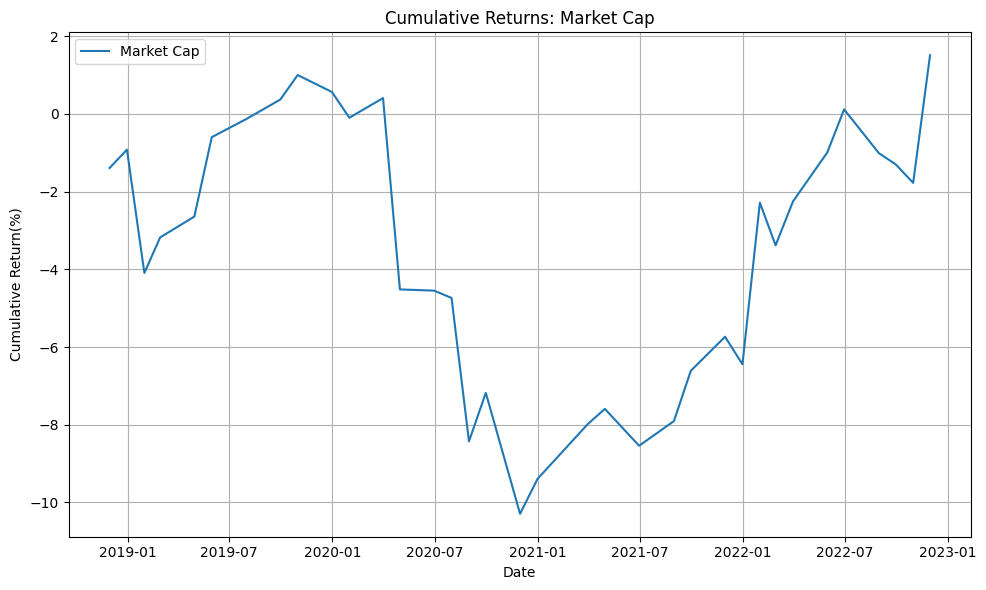

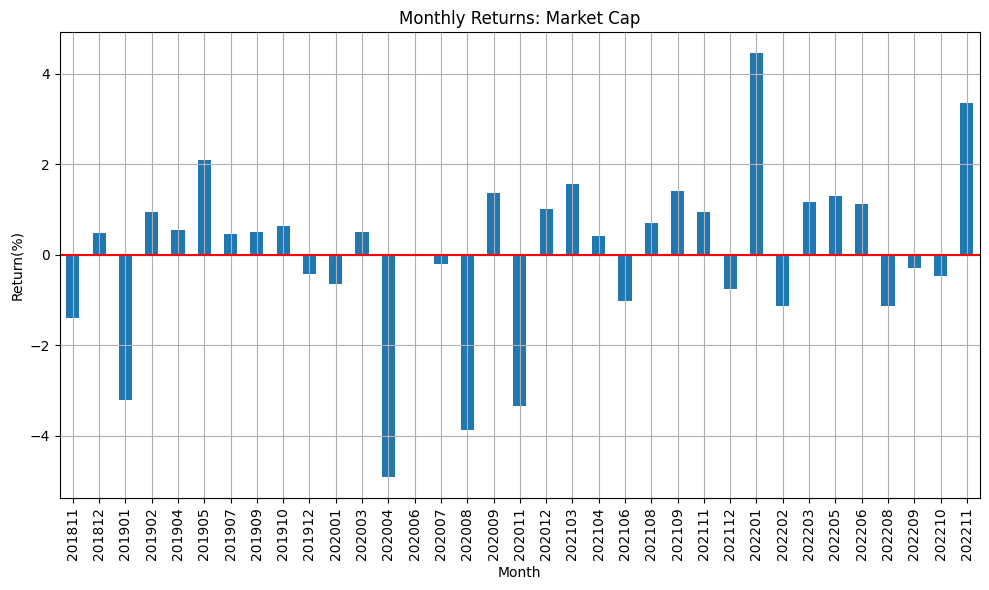

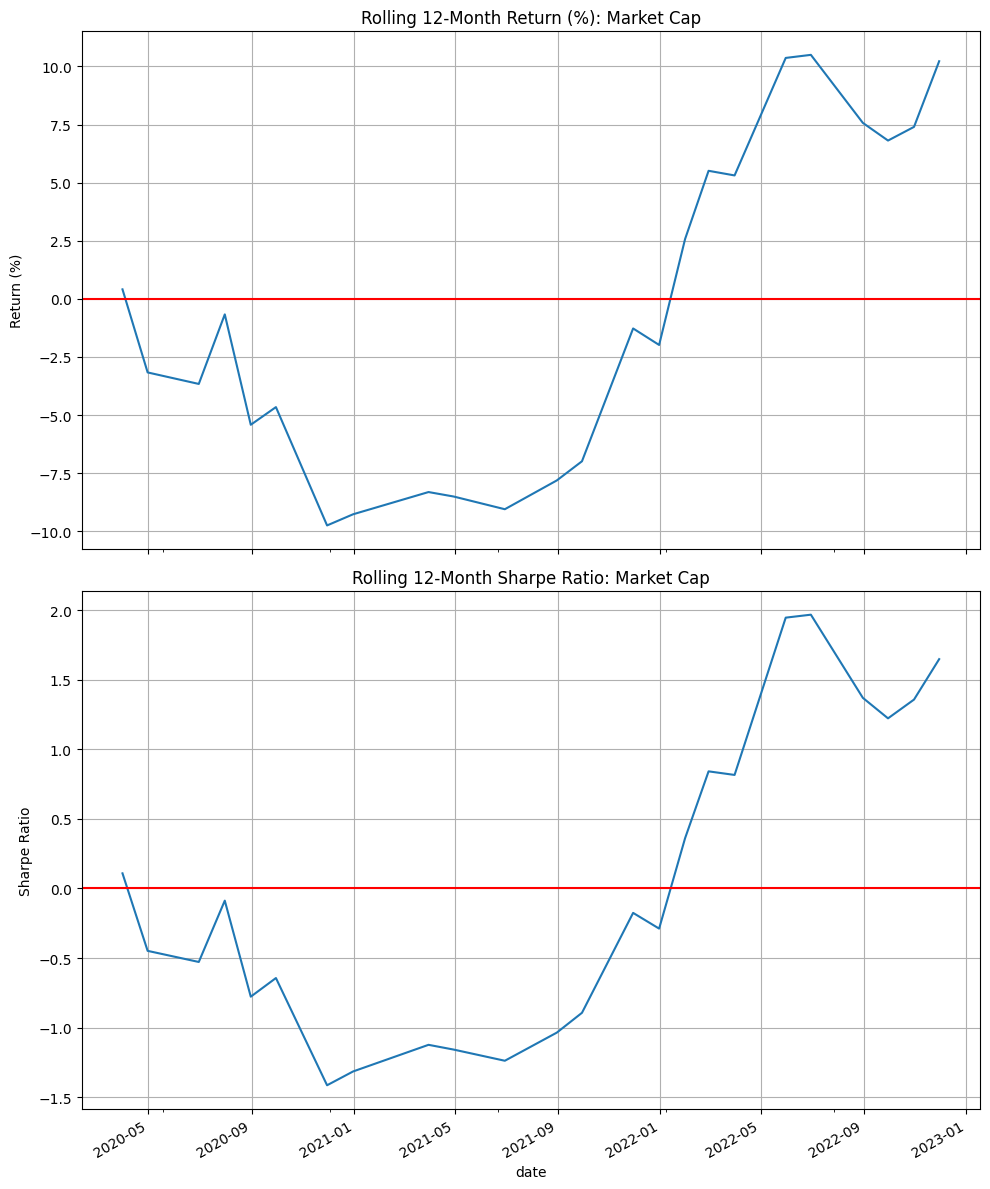


Performance Results for Turnover:


,Annualized Return (%),Monthly Return (bps),Monthly Vol. (%),Sharpe Ratio,Max Drawdown (%)
Turnover,-2.672194,-22.545764,1.491378,-0.523682,505.570037


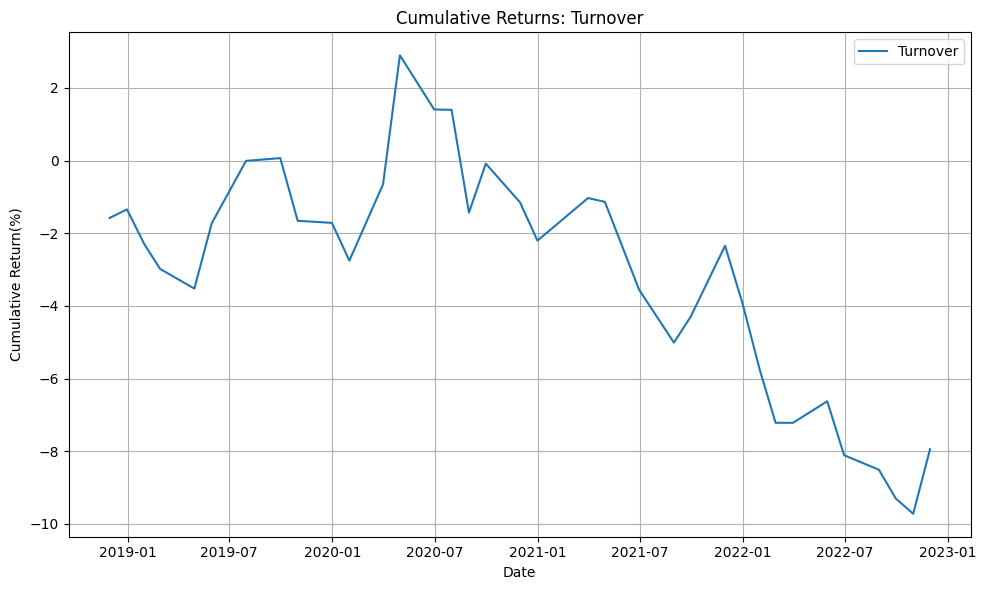

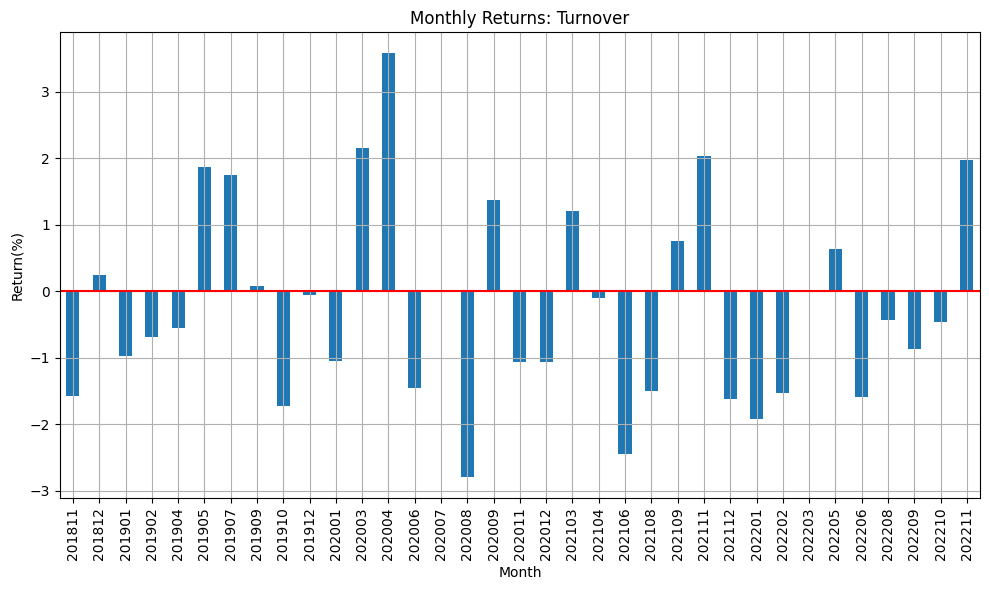

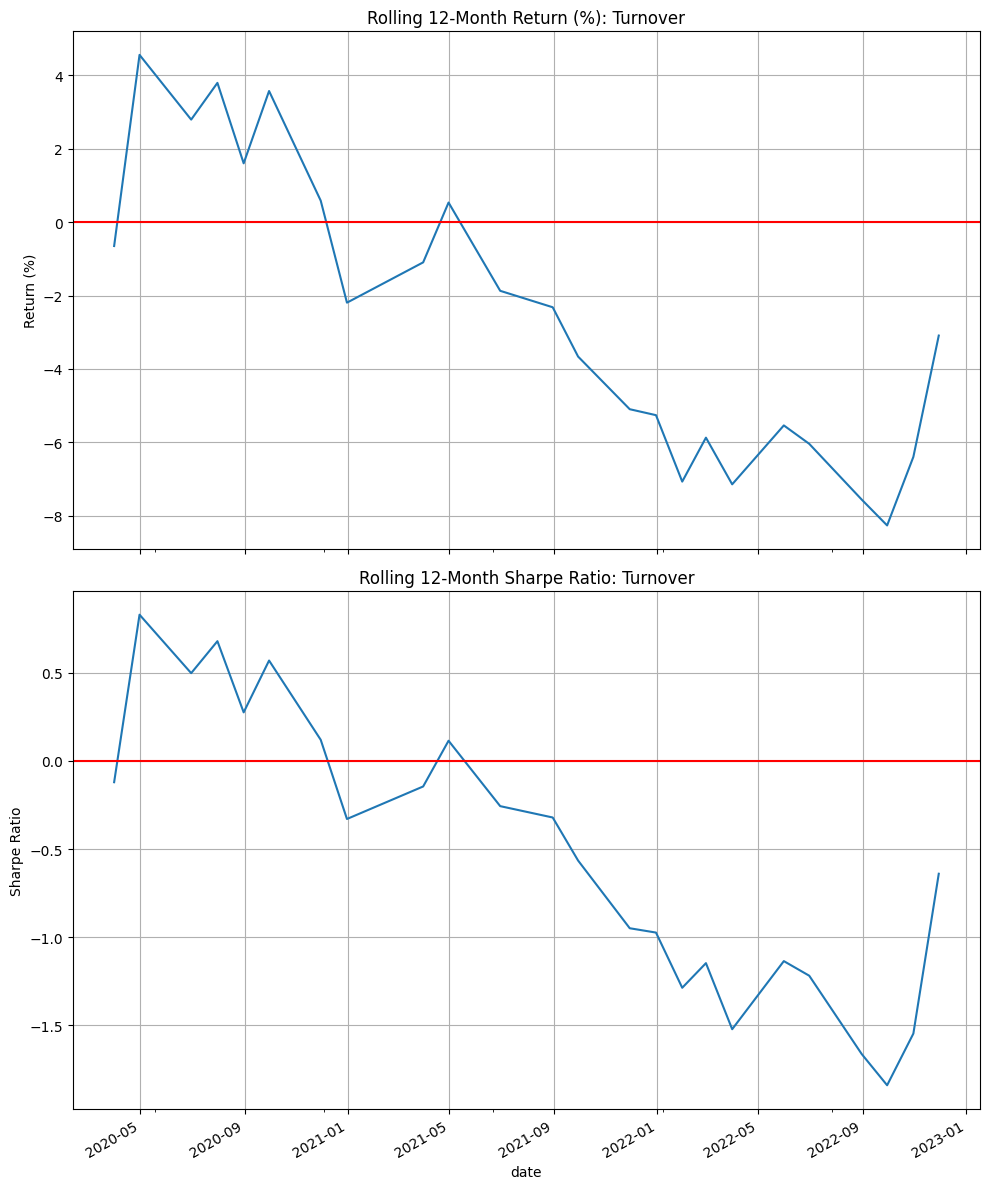


Performance Results for Illiquidity:


,Annualized Return (%),Monthly Return (bps),Monthly Vol. (%),Sharpe Ratio,Max Drawdown (%)
Illiquidity,5.158581,42.004073,2.34689,0.619996,184.726498


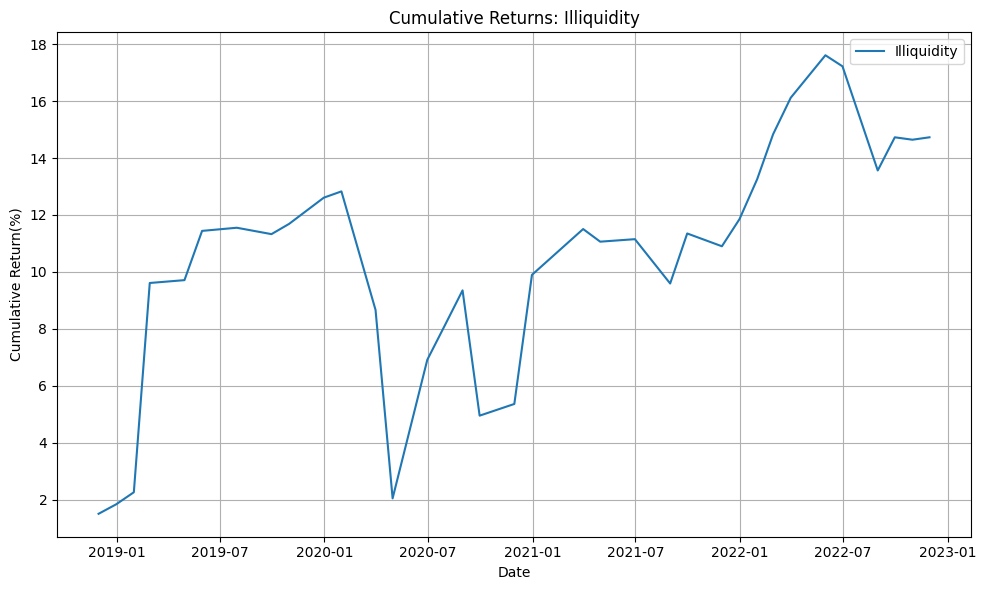

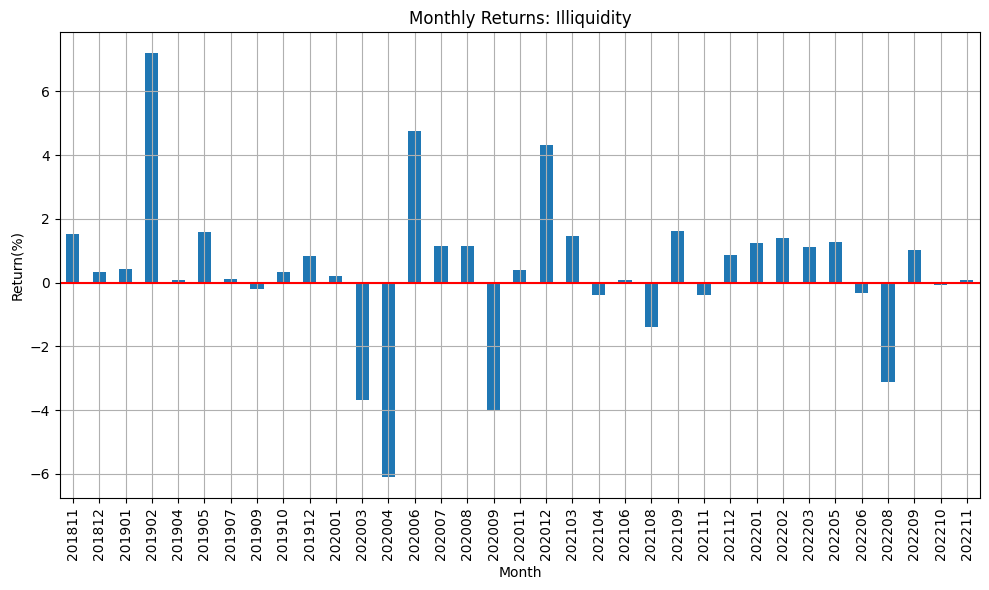

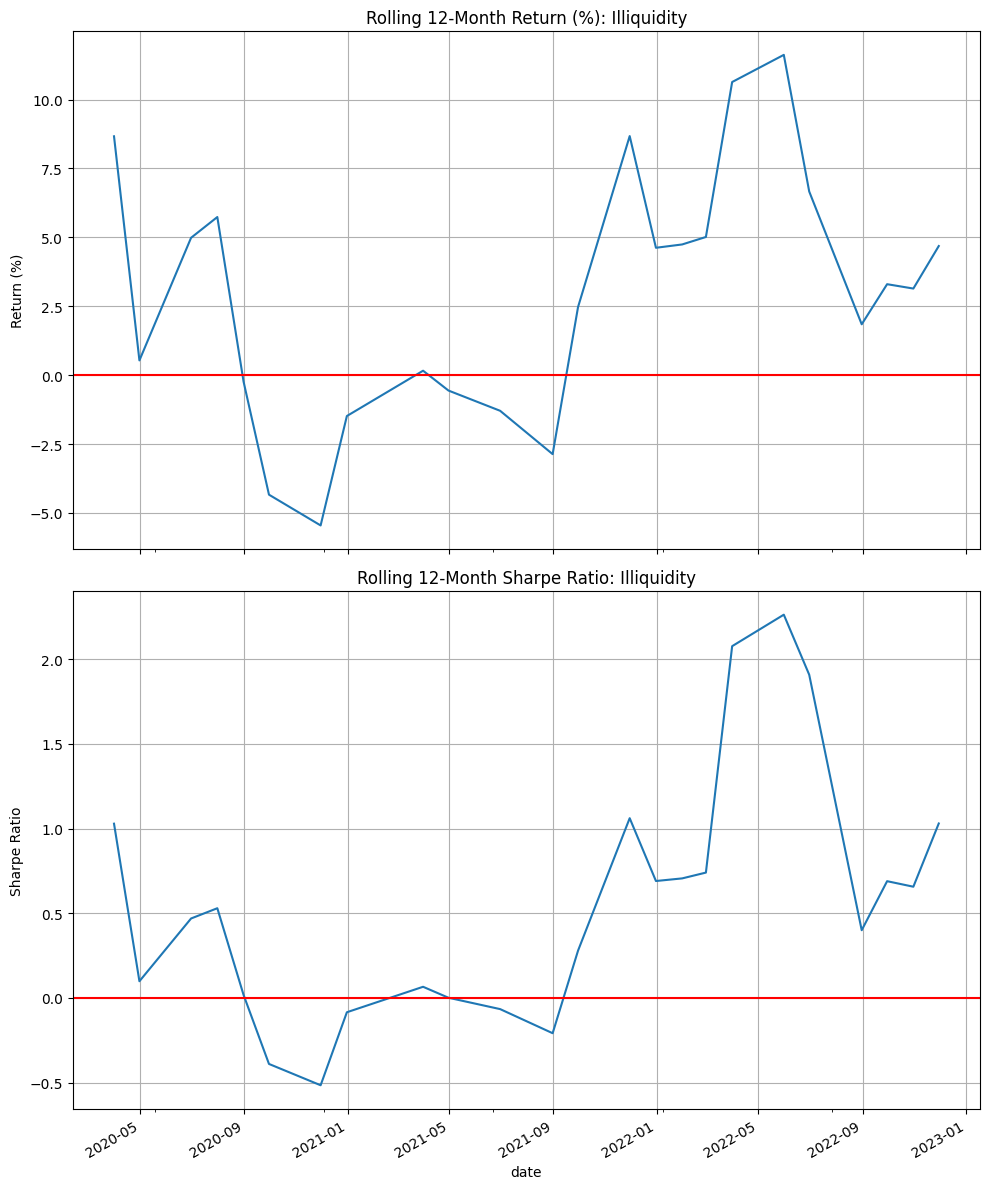

create_benchmark_portfolios completed in 33.02 seconds (0.55 minutes)

Preparing data for performance attribution...
Reading Fama-French factors from CSV file...
Successfully loaded 59 months of factor data

Processing avg_corr method


Computing avg_corr portfolios:   0%|          | 0/35 [00:00<?, ?it/s]

Computing avg_corr lead-lag matrix for 100576 pairs...


Computing avg_corr batches:   0%|          | 0/202 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.88 seconds (0.71 minutes)
Computing avg_corr lead-lag matrix for 97020 pairs...


Computing avg_corr batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.41 seconds (0.71 minutes)
Computing avg_corr lead-lag matrix for 97903 pairs...


Computing avg_corr batches:   0%|          | 0/196 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.37 seconds (0.71 minutes)
Computing avg_corr lead-lag matrix for 98790 pairs...


Computing avg_corr batches:   0%|          | 0/198 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.88 seconds (0.70 minutes)
Computing avg_corr lead-lag matrix for 101926 pairs...


Computing avg_corr batches:   0%|          | 0/204 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.74 seconds (0.71 minutes)
Computing avg_corr lead-lag matrix for 102378 pairs...


Computing avg_corr batches:   0%|          | 0/205 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 43.88 seconds (0.73 minutes)
Computing avg_corr lead-lag matrix for 104196 pairs...


Computing avg_corr batches:   0%|          | 0/209 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 44.83 seconds (0.75 minutes)
Computing avg_corr lead-lag matrix for 102831 pairs...


Computing avg_corr batches:   0%|          | 0/206 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 44.02 seconds (0.73 minutes)
Computing avg_corr lead-lag matrix for 100128 pairs...


Computing avg_corr batches:   0%|          | 0/201 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 46.84 seconds (0.78 minutes)
Computing avg_corr lead-lag matrix for 99681 pairs...


Computing avg_corr batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.83 seconds (0.71 minutes)
Computing avg_corr lead-lag matrix for 99681 pairs...


Computing avg_corr batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.82 seconds (0.71 minutes)
Computing avg_corr lead-lag matrix for 99235 pairs...


Computing avg_corr batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 40.42 seconds (0.67 minutes)
Computing avg_corr lead-lag matrix for 99681 pairs...


Computing avg_corr batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.43 seconds (0.71 minutes)
Computing avg_corr lead-lag matrix for 95703 pairs...


Computing avg_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 40.99 seconds (0.68 minutes)
Computing avg_corr lead-lag matrix for 95703 pairs...


Computing avg_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 39.97 seconds (0.67 minutes)
Computing avg_corr lead-lag matrix for 93528 pairs...


Computing avg_corr batches:   0%|          | 0/188 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 39.71 seconds (0.66 minutes)
Computing avg_corr lead-lag matrix for 93961 pairs...


Computing avg_corr batches:   0%|          | 0/188 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 40.21 seconds (0.67 minutes)
Computing avg_corr lead-lag matrix for 95703 pairs...


Computing avg_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 38.64 seconds (0.64 minutes)
Computing avg_corr lead-lag matrix for 98346 pairs...


Computing avg_corr batches:   0%|          | 0/197 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.17 seconds (0.70 minutes)
Computing avg_corr lead-lag matrix for 97461 pairs...


Computing avg_corr batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.38 seconds (0.69 minutes)
Computing avg_corr lead-lag matrix for 101025 pairs...


Computing avg_corr batches:   0%|          | 0/203 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.02 seconds (0.70 minutes)
Computing avg_corr lead-lag matrix for 95266 pairs...


Computing avg_corr batches:   0%|          | 0/191 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 39.75 seconds (0.66 minutes)
Computing avg_corr lead-lag matrix for 94830 pairs...


Computing avg_corr batches:   0%|          | 0/190 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 40.84 seconds (0.68 minutes)
Computing avg_corr lead-lag matrix for 93096 pairs...


Computing avg_corr batches:   0%|          | 0/187 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 38.33 seconds (0.64 minutes)
Computing avg_corr lead-lag matrix for 93096 pairs...


Computing avg_corr batches:   0%|          | 0/187 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 39.66 seconds (0.66 minutes)
Computing avg_corr lead-lag matrix for 92665 pairs...


Computing avg_corr batches:   0%|          | 0/186 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 39.79 seconds (0.66 minutes)
Computing avg_corr lead-lag matrix for 95703 pairs...


Computing avg_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 39.14 seconds (0.65 minutes)
Computing avg_corr lead-lag matrix for 95703 pairs...


Computing avg_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.09 seconds (0.68 minutes)
Computing avg_corr lead-lag matrix for 97020 pairs...


Computing avg_corr batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.08 seconds (0.70 minutes)
Computing avg_corr lead-lag matrix for 99235 pairs...


Computing avg_corr batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.40 seconds (0.69 minutes)
Computing avg_corr lead-lag matrix for 99235 pairs...


Computing avg_corr batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.57 seconds (0.69 minutes)
Computing avg_corr lead-lag matrix for 95703 pairs...


Computing avg_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.03 seconds (0.68 minutes)
Computing avg_corr lead-lag matrix for 97461 pairs...


Computing avg_corr batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.83 seconds (0.70 minutes)
Computing avg_corr lead-lag matrix for 100128 pairs...


Computing avg_corr batches:   0%|          | 0/201 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.78 seconds (0.70 minutes)
Computing avg_corr lead-lag matrix for 100576 pairs...


Computing avg_corr batches:   0%|          | 0/202 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.35 seconds (0.71 minutes)

Performance Results for avg_corr:


,Annualized Return (%),Monthly Return (bps),Monthly Vol. (%),Sharpe Ratio,Max Drawdown (%)
avg_corr,-7.562771,-65.31938,1.386081,-1.632465,607.740649


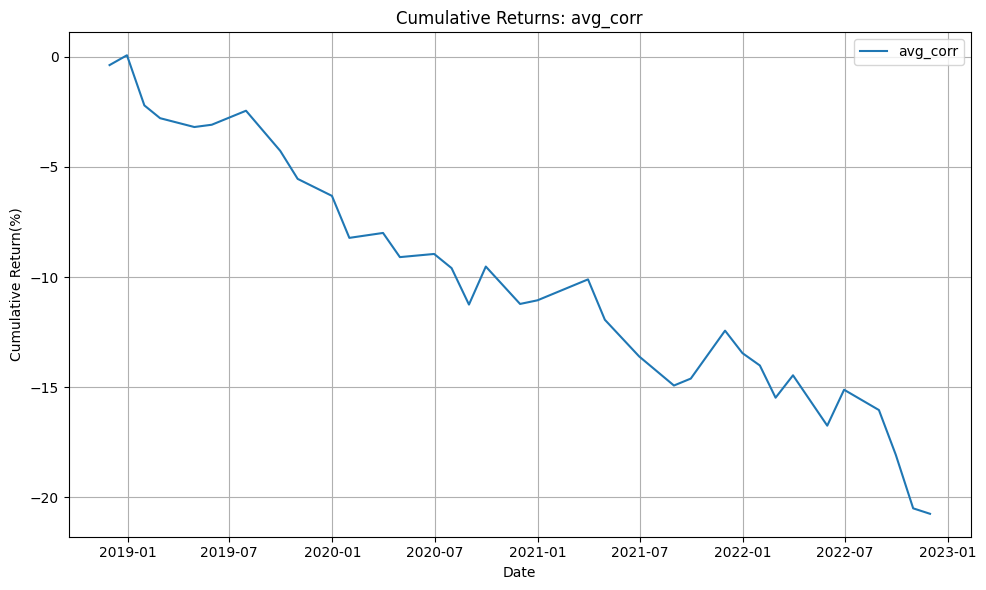

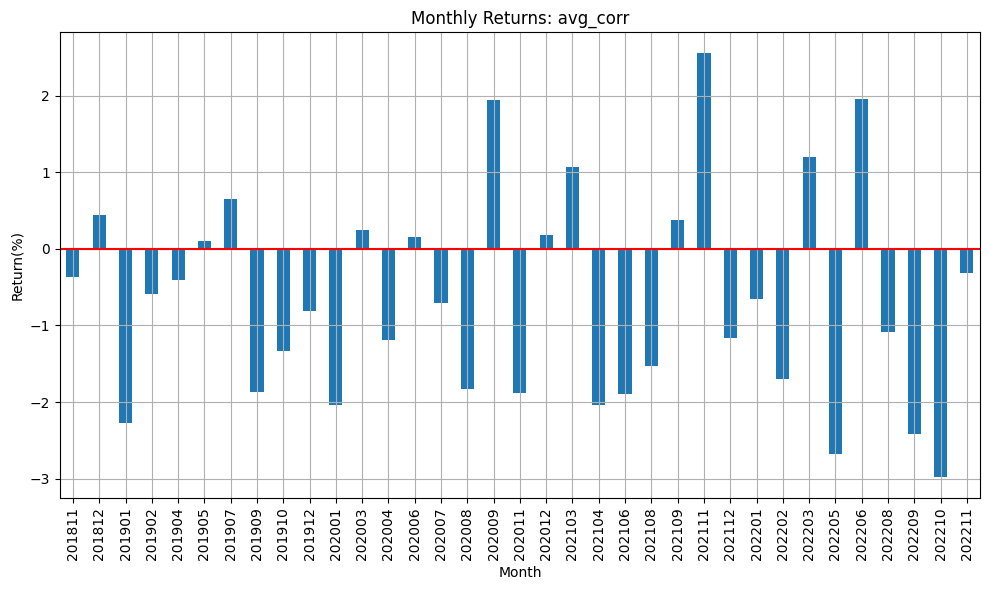

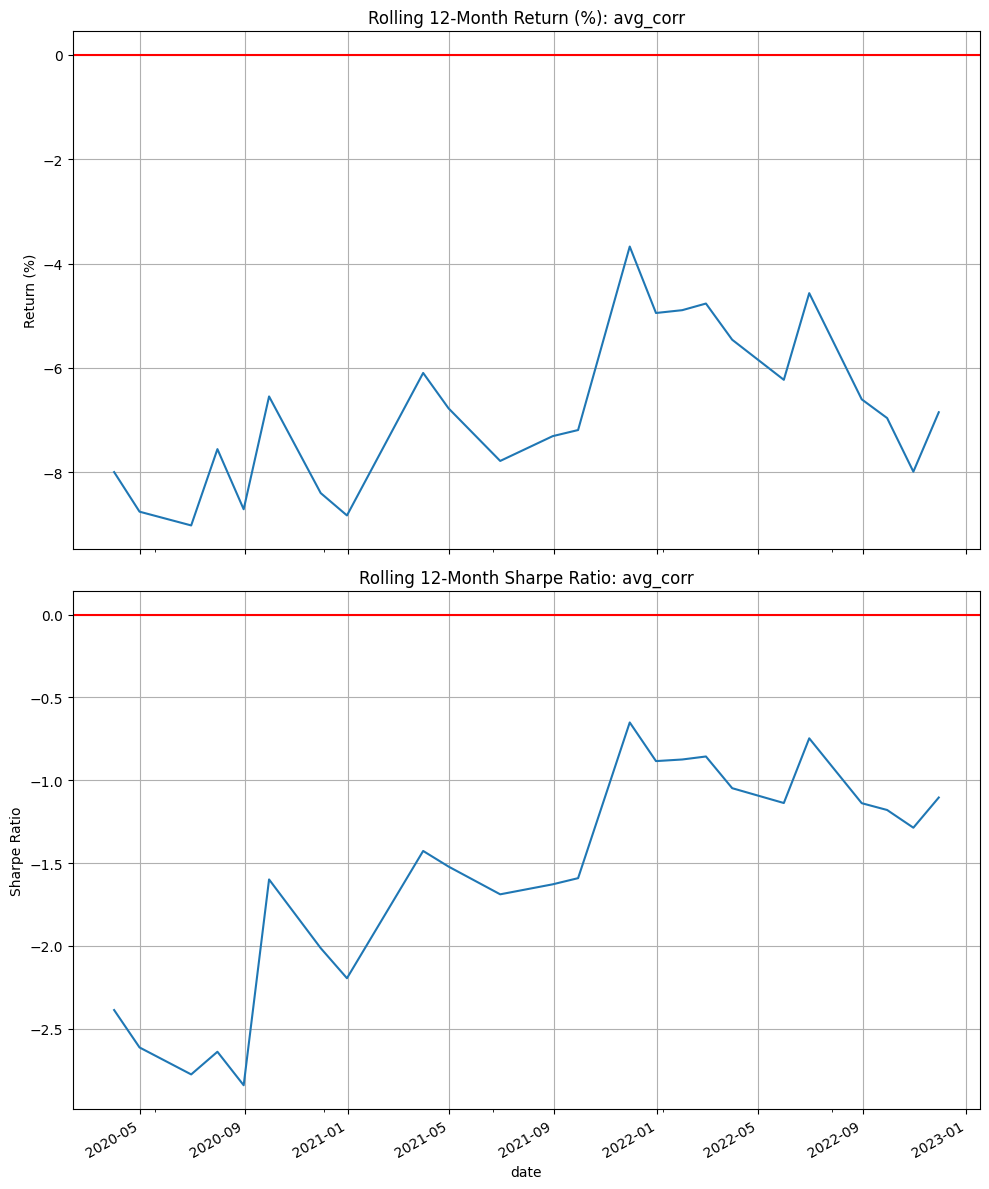

Running performance attribution for avg_corr...
Aligning data...
Check illiq_ret
2018-11-30    0.015079
2018-12-31    0.003286
2019-01-31    0.004151
dtype: float64
illiq_ret ready in Model 2
illiq_ret ready in Model 3

Table 1: Summary Statistics for AVG_CORR Strategy


,Mean Return (%),Std Dev (%),Sharpe Ratio,Skewness,Kurtosis,Min (%),Max (%),Hit Rate (%)
Portfolio,-7.84,4.80,-1.63,0.48,-0.37,-2.97,2.55,34.29
Market,11.59,21.14,0.55,-0.33,0.12,-13.39,13.65,62.86
Market Cap,0.72,6.47,0.11,-0.59,1.42,-4.90,4.45,57.14
Turnover,-2.71,5.17,-0.52,0.60,-0.18,-2.79,3.57,34.29



Table 8: Regression of AVG_CORR lead-lag portfolio against various benchmarks


,Alpha (%),t-stat,MktCap,t-stat (MktCap),Turnover,t-stat (Turnover),Illiquidity,Mkt-RF,SMB,HML,RMW,CMA,R-squared,t-stat (Illiquidity)
Model 1,-7.201330,-3.326444,0.283538,7.836533,0.310727,2.561070,NaN,NaN,NaN,NaN,NaN,NaN,0.299255,NaN
Model 2,-7.259428,-3.451482,0.274052,5.345183,0.327951,1.941886,0.022123,NaN,NaN,NaN,NaN,NaN,0.300228,0.274674
Model 3,-6.569858,-0.200353,0.374771,2.462018,0.278889,2.287808,-0.002675,-0.061408,0.20281,-0.126283,0.148416,-0.017534,0.513998,-0.037869



Processing levy_area method


Computing levy_area portfolios:   0%|          | 0/35 [00:00<?, ?it/s]

Computing levy_area lead-lag matrix for 100576 pairs...


Computing levy_area batches:   0%|          | 0/202 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.04 seconds (0.70 minutes)
Computing levy_area lead-lag matrix for 97020 pairs...


Computing levy_area batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.38 seconds (0.69 minutes)
Computing levy_area lead-lag matrix for 97903 pairs...


Computing levy_area batches:   0%|          | 0/196 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.86 seconds (0.71 minutes)
Computing levy_area lead-lag matrix for 98790 pairs...


Computing levy_area batches:   0%|          | 0/198 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 43.09 seconds (0.72 minutes)
Computing levy_area lead-lag matrix for 101926 pairs...


Computing levy_area batches:   0%|          | 0/204 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 44.26 seconds (0.74 minutes)
Computing levy_area lead-lag matrix for 102378 pairs...


Computing levy_area batches:   0%|          | 0/205 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 44.11 seconds (0.74 minutes)
Computing levy_area lead-lag matrix for 104196 pairs...


Computing levy_area batches:   0%|          | 0/209 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 45.16 seconds (0.75 minutes)
Computing levy_area lead-lag matrix for 102831 pairs...


Computing levy_area batches:   0%|          | 0/206 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 44.06 seconds (0.73 minutes)
Computing levy_area lead-lag matrix for 100128 pairs...


Computing levy_area batches:   0%|          | 0/201 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 44.12 seconds (0.74 minutes)
Computing levy_area lead-lag matrix for 99681 pairs...


Computing levy_area batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 43.54 seconds (0.73 minutes)
Computing levy_area lead-lag matrix for 99681 pairs...


Computing levy_area batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 44.12 seconds (0.74 minutes)
Computing levy_area lead-lag matrix for 99235 pairs...


Computing levy_area batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 43.69 seconds (0.73 minutes)
Computing levy_area lead-lag matrix for 99681 pairs...


Computing levy_area batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.90 seconds (0.70 minutes)
Computing levy_area lead-lag matrix for 95703 pairs...


Computing levy_area batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.10 seconds (0.68 minutes)
Computing levy_area lead-lag matrix for 95703 pairs...


Computing levy_area batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.29 seconds (0.70 minutes)
Computing levy_area lead-lag matrix for 93528 pairs...


Computing levy_area batches:   0%|          | 0/188 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 39.53 seconds (0.66 minutes)
Computing levy_area lead-lag matrix for 93961 pairs...


Computing levy_area batches:   0%|          | 0/188 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.48 seconds (0.69 minutes)
Computing levy_area lead-lag matrix for 95703 pairs...


Computing levy_area batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.40 seconds (0.71 minutes)
Computing levy_area lead-lag matrix for 98346 pairs...


Computing levy_area batches:   0%|          | 0/197 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.41 seconds (0.71 minutes)
Computing levy_area lead-lag matrix for 97461 pairs...


Computing levy_area batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.00 seconds (0.70 minutes)
Computing levy_area lead-lag matrix for 101025 pairs...


Computing levy_area batches:   0%|          | 0/203 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 44.55 seconds (0.74 minutes)
Computing levy_area lead-lag matrix for 95266 pairs...


Computing levy_area batches:   0%|          | 0/191 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.32 seconds (0.71 minutes)
Computing levy_area lead-lag matrix for 94830 pairs...


Computing levy_area batches:   0%|          | 0/190 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 40.50 seconds (0.68 minutes)
Computing levy_area lead-lag matrix for 93096 pairs...


Computing levy_area batches:   0%|          | 0/187 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 39.90 seconds (0.67 minutes)
Computing levy_area lead-lag matrix for 93096 pairs...


Computing levy_area batches:   0%|          | 0/187 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 41.65 seconds (0.69 minutes)
Computing levy_area lead-lag matrix for 92665 pairs...


Computing levy_area batches:   0%|          | 0/186 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 38.95 seconds (0.65 minutes)
Computing levy_area lead-lag matrix for 95703 pairs...


Computing levy_area batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.62 seconds (0.71 minutes)
Computing levy_area lead-lag matrix for 95703 pairs...


Computing levy_area batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.56 seconds (0.71 minutes)
Computing levy_area lead-lag matrix for 97020 pairs...


Computing levy_area batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.45 seconds (0.71 minutes)
Computing levy_area lead-lag matrix for 99235 pairs...


Computing levy_area batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.11 seconds (0.70 minutes)
Computing levy_area lead-lag matrix for 99235 pairs...


Computing levy_area batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 43.77 seconds (0.73 minutes)
Computing levy_area lead-lag matrix for 95703 pairs...


Computing levy_area batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.11 seconds (0.70 minutes)
Computing levy_area lead-lag matrix for 97461 pairs...


Computing levy_area batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.20 seconds (0.70 minutes)
Computing levy_area lead-lag matrix for 100128 pairs...


Computing levy_area batches:   0%|          | 0/201 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 42.92 seconds (0.72 minutes)
Computing levy_area lead-lag matrix for 100576 pairs...


Computing levy_area batches:   0%|          | 0/202 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 43.95 seconds (0.73 minutes)

Performance Results for levy_area:


,Annualized Return (%),Monthly Return (bps),Monthly Vol. (%),Sharpe Ratio,Max Drawdown (%)
levy_area,-6.88572,-59.275811,1.299761,-1.579809,595.696529


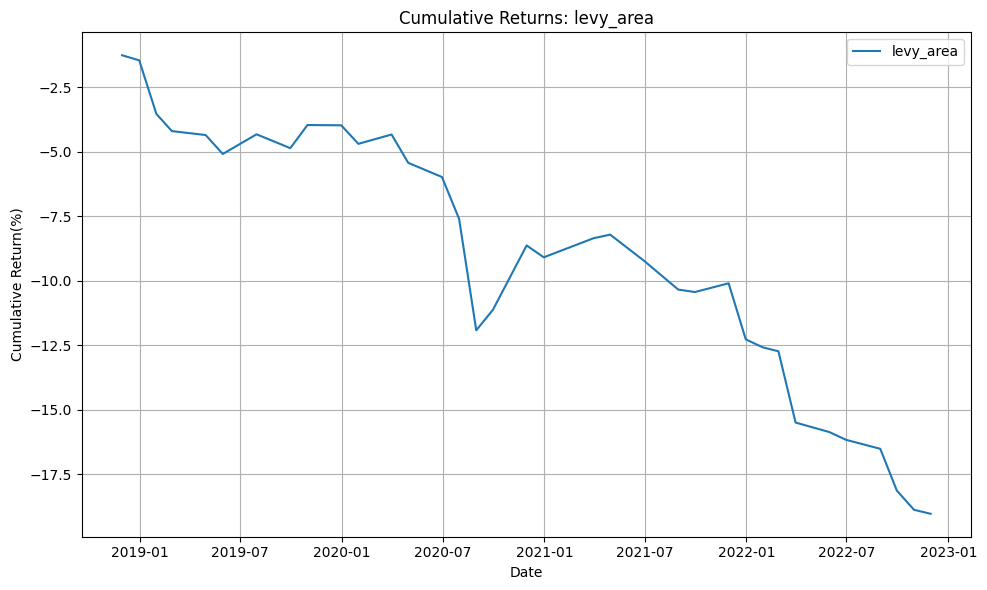

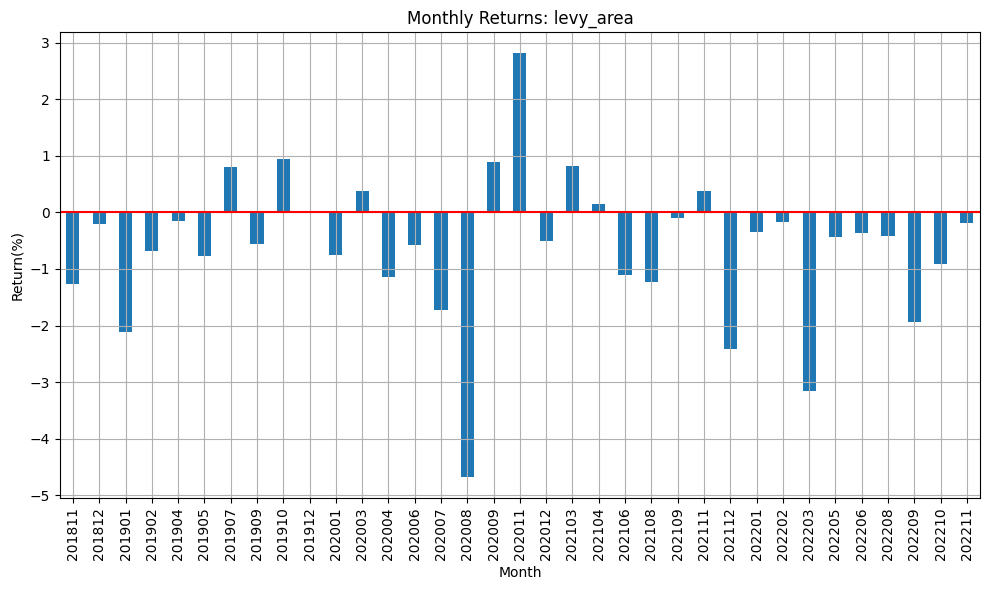

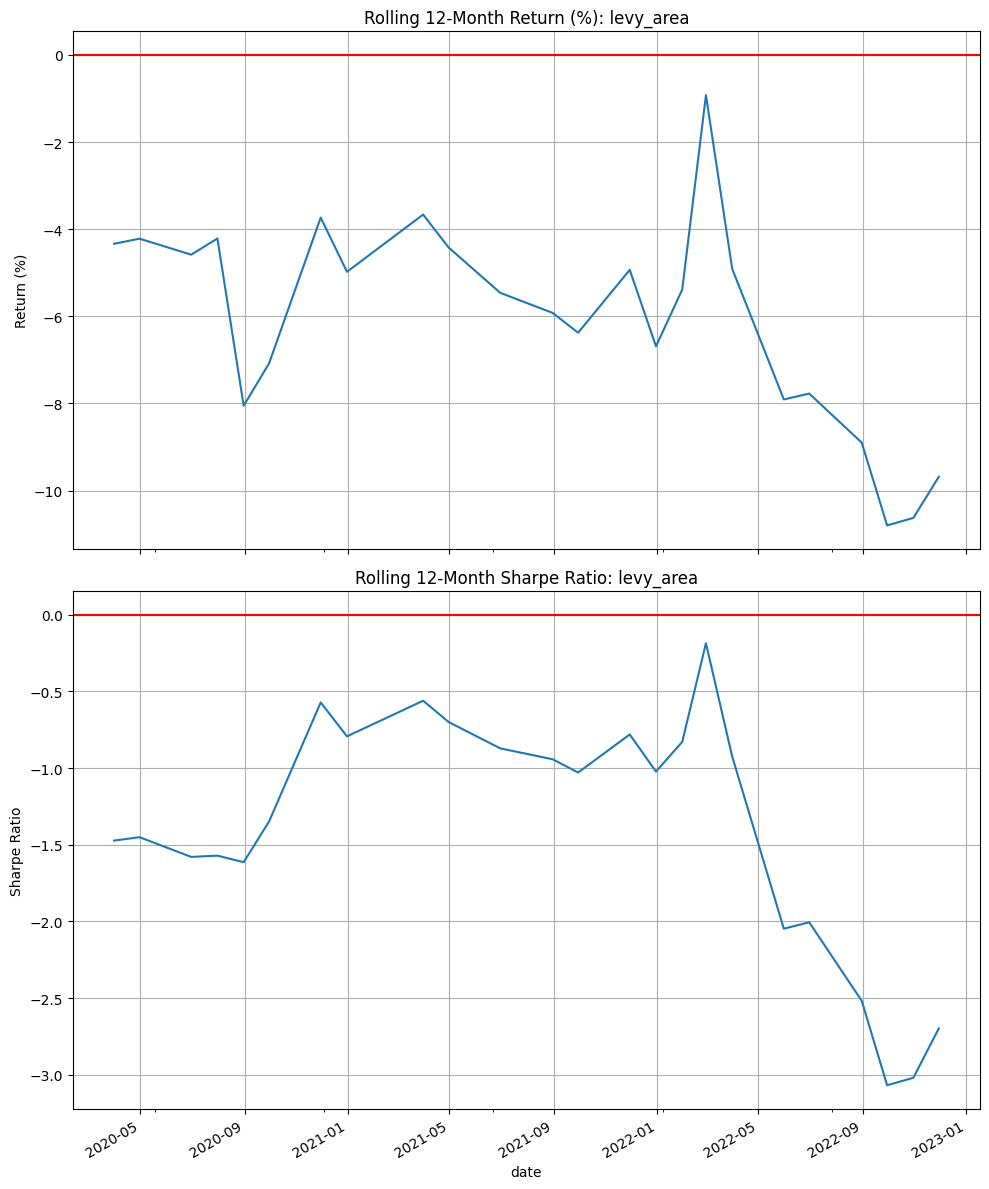

Running performance attribution for levy_area...
Aligning data...
Check illiq_ret
2018-11-30    0.015079
2018-12-31    0.003286
2019-01-31    0.004151
dtype: float64
illiq_ret ready in Model 2
illiq_ret ready in Model 3

Table 1: Summary Statistics for LEVY_AREA Strategy


,Mean Return (%),Std Dev (%),Sharpe Ratio,Skewness,Kurtosis,Min (%),Max (%),Hit Rate (%)
Portfolio,-7.11,4.50,-1.58,-0.63,2.81,-4.67,2.81,22.86
Market,11.59,21.14,0.55,-0.33,0.12,-13.39,13.65,62.86
Market Cap,0.72,6.47,0.11,-0.59,1.42,-4.90,4.45,57.14
Turnover,-2.71,5.17,-0.52,0.60,-0.18,-2.79,3.57,34.29



Table 8: Regression of LEVY_AREA lead-lag portfolio against various benchmarks


,Alpha (%),t-stat,MktCap,t-stat (MktCap),Turnover,t-stat (Turnover),Illiquidity,Mkt-RF,SMB,HML,RMW,CMA,R-squared,t-stat (Illiquidity)
Model 1,-6.539870,-3.175784,0.156615,1.540032,0.253458,2.899980,NaN,NaN,NaN,NaN,NaN,NaN,0.156504,NaN
Model 2,-6.402063,-3.132806,0.179114,1.618408,0.212602,2.021766,-0.052476,NaN,NaN,NaN,NaN,NaN,0.162733,-1.311877
Model 3,-4.184260,-0.524539,0.377725,3.374088,0.253190,2.907166,-0.135881,-0.002983,0.227343,-0.000073,-0.060687,-0.044716,0.365915,-3.623408



Processing max_corr method


Computing max_corr portfolios:   0%|          | 0/35 [00:00<?, ?it/s]

Computing max_corr lead-lag matrix for 100576 pairs...


Computing max_corr batches:   0%|          | 0/202 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 65.53 seconds (1.09 minutes)
Computing max_corr lead-lag matrix for 97020 pairs...


Computing max_corr batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 63.10 seconds (1.05 minutes)
Computing max_corr lead-lag matrix for 97903 pairs...


Computing max_corr batches:   0%|          | 0/196 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 62.86 seconds (1.05 minutes)
Computing max_corr lead-lag matrix for 98790 pairs...


Computing max_corr batches:   0%|          | 0/198 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 62.92 seconds (1.05 minutes)
Computing max_corr lead-lag matrix for 101926 pairs...


Computing max_corr batches:   0%|          | 0/204 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 65.61 seconds (1.09 minutes)
Computing max_corr lead-lag matrix for 102378 pairs...


Computing max_corr batches:   0%|          | 0/205 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 67.25 seconds (1.12 minutes)
Computing max_corr lead-lag matrix for 104196 pairs...


Computing max_corr batches:   0%|          | 0/209 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 67.54 seconds (1.13 minutes)
Computing max_corr lead-lag matrix for 102831 pairs...


Computing max_corr batches:   0%|          | 0/206 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 66.69 seconds (1.11 minutes)
Computing max_corr lead-lag matrix for 100128 pairs...


Computing max_corr batches:   0%|          | 0/201 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 66.61 seconds (1.11 minutes)
Computing max_corr lead-lag matrix for 99681 pairs...


Computing max_corr batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 64.64 seconds (1.08 minutes)
Computing max_corr lead-lag matrix for 99681 pairs...


Computing max_corr batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 64.66 seconds (1.08 minutes)
Computing max_corr lead-lag matrix for 99235 pairs...


Computing max_corr batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 64.35 seconds (1.07 minutes)
Computing max_corr lead-lag matrix for 99681 pairs...


Computing max_corr batches:   0%|          | 0/200 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 64.99 seconds (1.08 minutes)
Computing max_corr lead-lag matrix for 95703 pairs...


Computing max_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 60.77 seconds (1.01 minutes)
Computing max_corr lead-lag matrix for 95703 pairs...


Computing max_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 61.15 seconds (1.02 minutes)
Computing max_corr lead-lag matrix for 93528 pairs...


Computing max_corr batches:   0%|          | 0/188 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 60.61 seconds (1.01 minutes)
Computing max_corr lead-lag matrix for 93961 pairs...


Computing max_corr batches:   0%|          | 0/188 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 60.99 seconds (1.02 minutes)
Computing max_corr lead-lag matrix for 95703 pairs...


Computing max_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 62.31 seconds (1.04 minutes)
Computing max_corr lead-lag matrix for 98346 pairs...


Computing max_corr batches:   0%|          | 0/197 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 64.15 seconds (1.07 minutes)
Computing max_corr lead-lag matrix for 97461 pairs...


Computing max_corr batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 63.85 seconds (1.06 minutes)
Computing max_corr lead-lag matrix for 101025 pairs...


Computing max_corr batches:   0%|          | 0/203 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 65.83 seconds (1.10 minutes)
Computing max_corr lead-lag matrix for 95266 pairs...


Computing max_corr batches:   0%|          | 0/191 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 62.62 seconds (1.04 minutes)
Computing max_corr lead-lag matrix for 94830 pairs...


Computing max_corr batches:   0%|          | 0/190 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 61.57 seconds (1.03 minutes)
Computing max_corr lead-lag matrix for 93096 pairs...


Computing max_corr batches:   0%|          | 0/187 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 60.17 seconds (1.00 minutes)
Computing max_corr lead-lag matrix for 93096 pairs...


Computing max_corr batches:   0%|          | 0/187 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 60.02 seconds (1.00 minutes)
Computing max_corr lead-lag matrix for 92665 pairs...


Computing max_corr batches:   0%|          | 0/186 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 60.02 seconds (1.00 minutes)
Computing max_corr lead-lag matrix for 95703 pairs...


Computing max_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 62.00 seconds (1.03 minutes)
Computing max_corr lead-lag matrix for 95703 pairs...


Computing max_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 61.76 seconds (1.03 minutes)
Computing max_corr lead-lag matrix for 97020 pairs...


Computing max_corr batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 63.85 seconds (1.06 minutes)
Computing max_corr lead-lag matrix for 99235 pairs...


Computing max_corr batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 65.15 seconds (1.09 minutes)
Computing max_corr lead-lag matrix for 99235 pairs...


Computing max_corr batches:   0%|          | 0/199 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 65.07 seconds (1.08 minutes)
Computing max_corr lead-lag matrix for 95703 pairs...


Computing max_corr batches:   0%|          | 0/192 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 63.58 seconds (1.06 minutes)
Computing max_corr lead-lag matrix for 97461 pairs...


Computing max_corr batches:   0%|          | 0/195 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 63.08 seconds (1.05 minutes)
Computing max_corr lead-lag matrix for 100128 pairs...


Computing max_corr batches:   0%|          | 0/201 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 65.37 seconds (1.09 minutes)
Computing max_corr lead-lag matrix for 100576 pairs...


Computing max_corr batches:   0%|          | 0/202 [00:00<?, ?it/s]

compute_lead_lag_matrix completed in 65.77 seconds (1.10 minutes)

Performance Results for max_corr:


,Annualized Return (%),Monthly Return (bps),Monthly Vol. (%),Sharpe Ratio,Max Drawdown (%)
max_corr,-4.933518,-42.072689,1.44197,-1.010729,410.11354


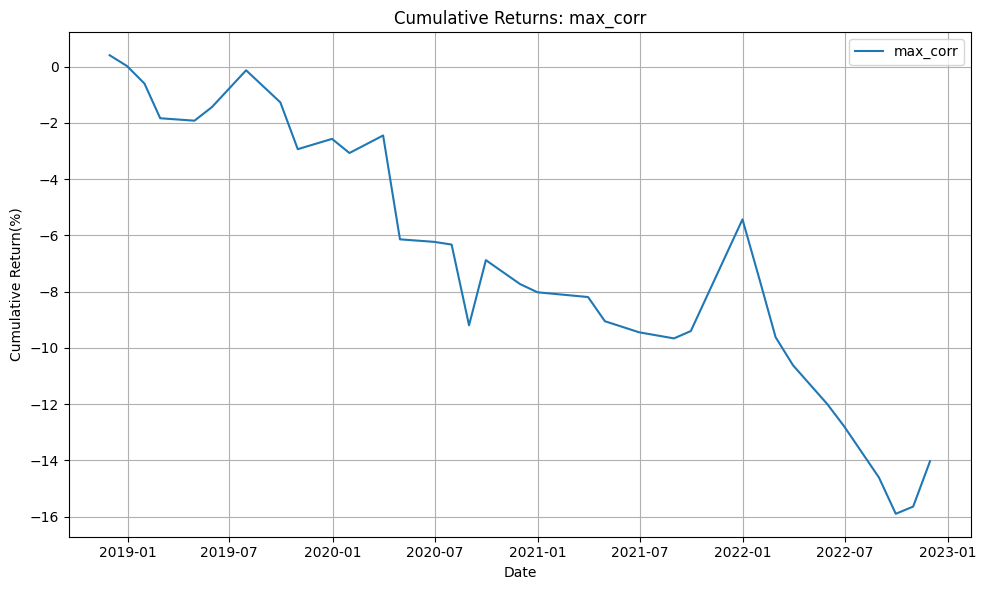

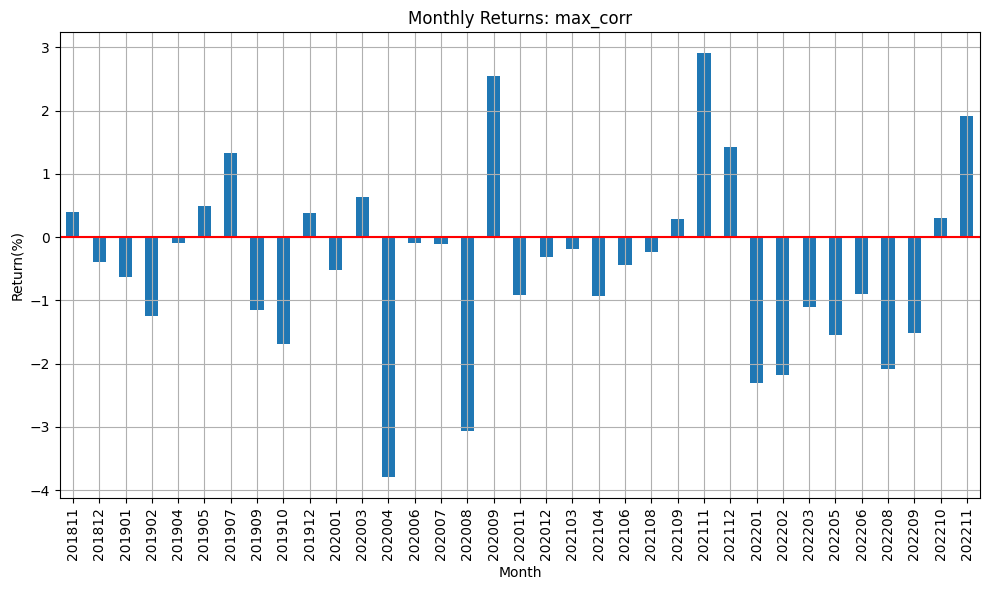

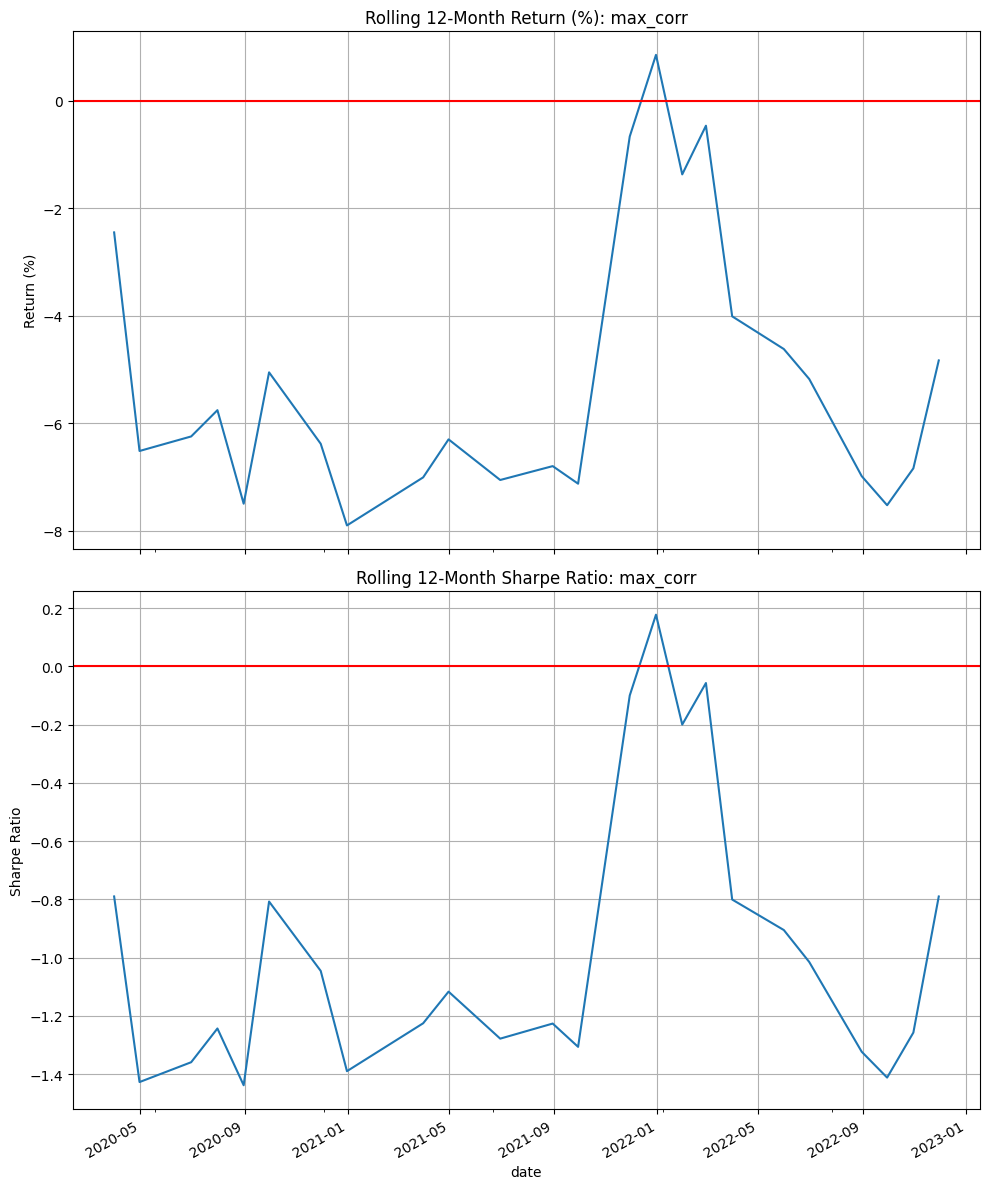

Running performance attribution for max_corr...
Aligning data...
Check illiq_ret
2018-11-30    0.015079
2018-12-31    0.003286
2019-01-31    0.004151
dtype: float64
illiq_ret ready in Model 2
illiq_ret ready in Model 3

Table 1: Summary Statistics for MAX_CORR Strategy


,Mean Return (%),Std Dev (%),Sharpe Ratio,Skewness,Kurtosis,Min (%),Max (%),Hit Rate (%)
Portfolio,-5.05,5.00,-1.01,0.12,0.51,-3.78,2.91,31.43
Market,11.59,21.14,0.55,-0.33,0.12,-13.39,13.65,62.86
Market Cap,0.72,6.47,0.11,-0.59,1.42,-4.90,4.45,57.14
Turnover,-2.71,5.17,-0.52,0.60,-0.18,-2.79,3.57,34.29



Table 8: Regression of MAX_CORR lead-lag portfolio against various benchmarks


,Alpha (%),t-stat,MktCap,t-stat (MktCap),Turnover,t-stat (Turnover),Illiquidity,Mkt-RF,SMB,HML,RMW,CMA,R-squared,t-stat (Illiquidity)
Model 1,-4.519879,-2.003581,0.274594,1.321839,0.268377,1.467421,NaN,NaN,NaN,NaN,NaN,NaN,0.235621,NaN
Model 2,-4.590360,-1.946303,0.263087,1.248072,0.289273,1.542514,0.026839,NaN,NaN,NaN,NaN,NaN,0.236944,0.290255
Model 3,-6.107720,1.202736,0.393179,1.588930,0.188270,1.387627,-0.011773,0.012781,0.091748,-0.134068,0.125293,0.086499,0.335635,-0.098172



Comparing all methods...

Results saved to lead_lag_results.pickle

Comparing methods: avg_corr, levy_area, max_corr


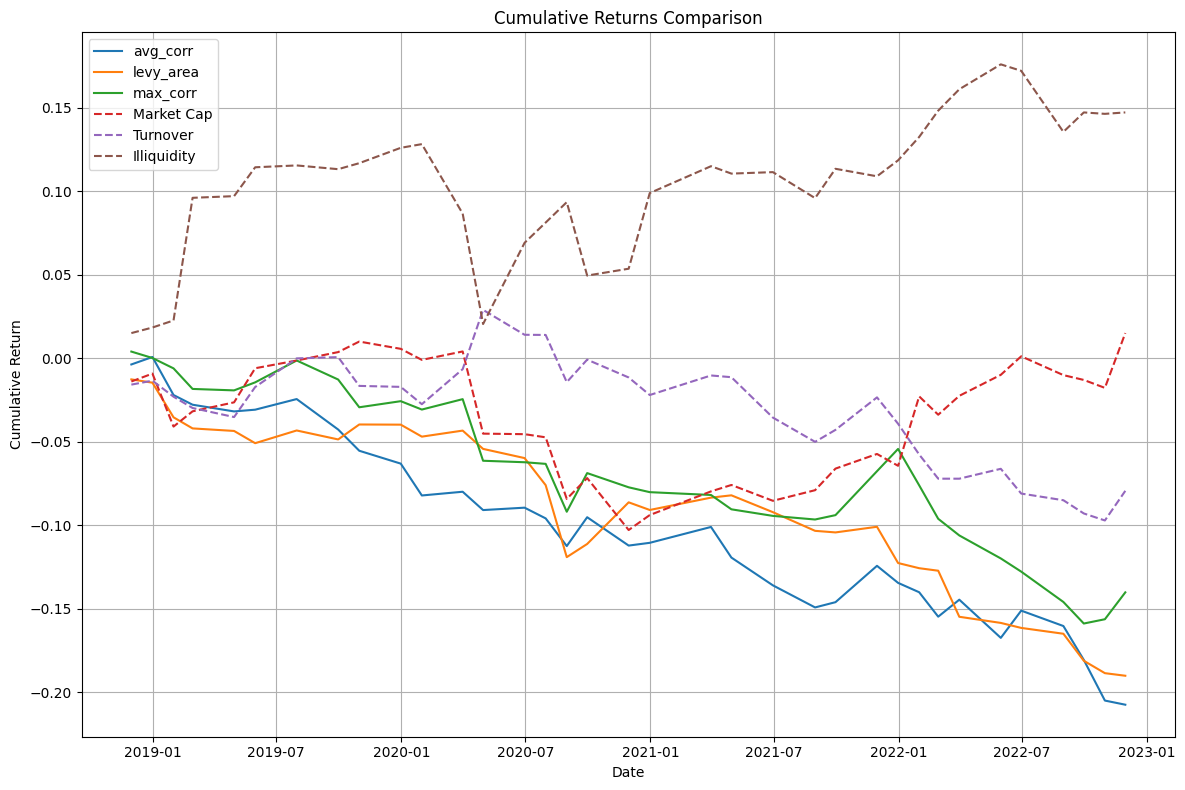


Performance Summary:


,Annualized Return (%),Monthly Return (bps),Monthly Vol. (%),Sharpe Ratio,Max Drawdown (%)
avg_corr,-7.562771,-65.319380,1.386081,-1.632465,607.740649
levy_area,-6.885720,-59.275811,1.299761,-1.579809,595.696529
max_corr,-4.933518,-42.072689,1.441970,-1.010729,410.113540
Market Cap,0.720698,5.986073,1.867315,0.111049,767.523720
Turnover,-2.672194,-22.545764,1.491378,-0.523682,505.570037
Illiquidity,5.158581,42.004073,2.346890,0.619996,184.726498


run_lead_lag_analysis completed in 5252.17 seconds (87.54 minutes)


In [ ]:
# Run the analysis with immediate results for each method
if __name__ == "__main__":
    # You can run just one method at a time for debugging
    #methods = ['levy_area']  # Uncomment to run only one method

    performance, cumulative_returns, portfolio_returns, attribution = run_lead_lag_analysis(
        lookback_window=6,  # 6 months data
        n_leaders_pct=0.2,   # Top 20% as leaders
        n_followers_pct=0.2,  # Bottom 20% as followers
        top_mktcap=500,      # Use top 500 market cap stocks each month
        methods=['avg_corr','levy_area','max_corr'],
        debug_mode=True,       # Enable additional debugging output
        save_results=True
    )

# Run Comparison Only

Loaded results from lead_lag_results.pickle

Comparing methods: avg_corr, levy_area, max_corr


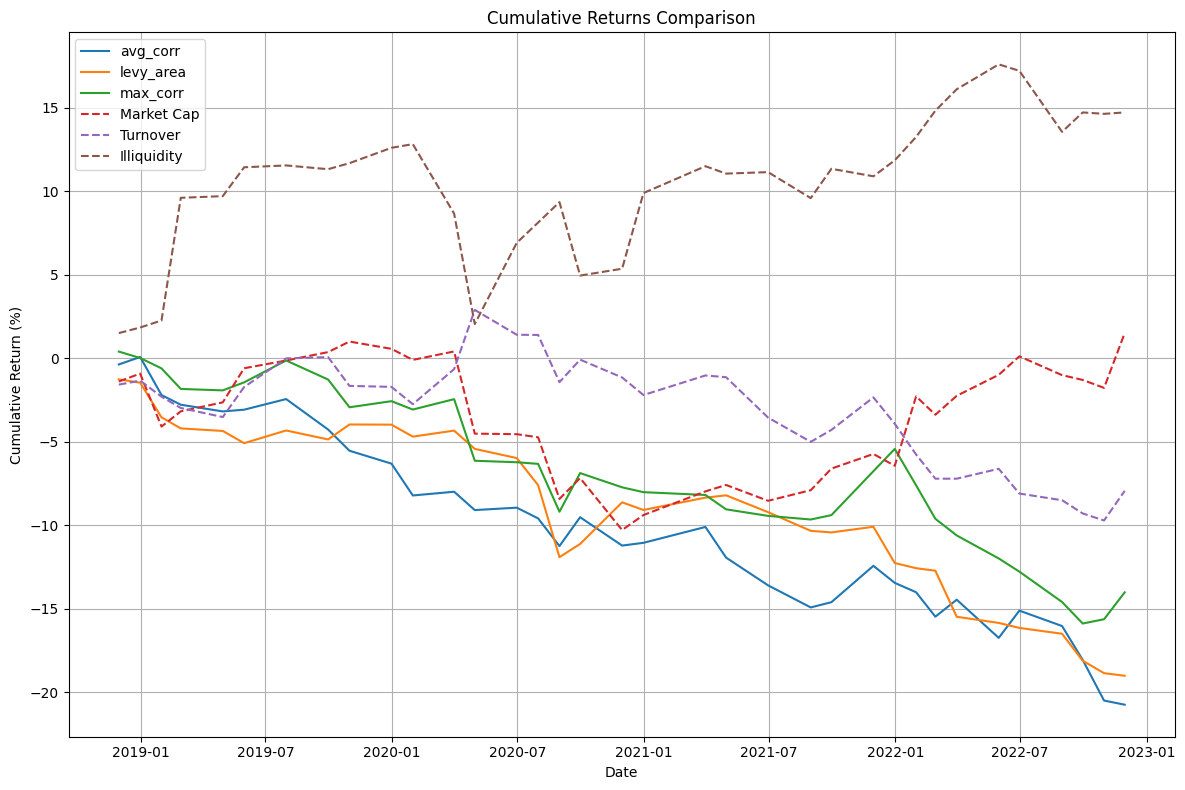

Annualized Return (%)      0.720698
Monthly Return (bps)       5.986073
Monthly Vol. (%)           1.867315
Sharpe Ratio               0.111049
Max Drawdown (%)         767.523720
Compound Return (%)        1.509220
Name: Market Cap, dtype: float64
Annualized Return (%)     -2.672194
Monthly Return (bps)     -22.545764
Monthly Vol. (%)           1.491378
Sharpe Ratio              -0.523682
Max Drawdown (%)         505.570037
Compound Return (%)       -7.944389
Name: Turnover, dtype: float64
Annualized Return (%)      5.158581
Monthly Return (bps)      42.004073
Monthly Vol. (%)           2.346890
Sharpe Ratio               0.619996
Max Drawdown (%)         184.726498
Compound Return (%)       14.728650
Name: Illiquidity, dtype: float64

Performance Summary:


,Compound Return (%),Monthly Return (bps),Monthly Vol. (%),Sharpe Ratio,Max Drawdown (%)
avg_corr,-20.76,-65.32,1.39,-1.63,607.74
levy_area,-19.02,-59.28,1.30,-1.58,595.70
max_corr,-14.03,-42.07,1.44,-1.01,410.11
Market Cap,1.51,5.99,1.87,0.11,767.52
Turnover,-7.94,-22.55,1.49,-0.52,505.57
Illiquidity,14.73,42.00,2.35,0.62,184.73


In [ ]:
results = load_results()
if results:
    compare_methods(
        methods=['avg_corr','levy_area','max_corr'],
        portfolio_data=results
    )